In [1]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
import time


from scipy.stats import skew

from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error

In [2]:
df_raw= pd.read_csv('../data/House_Rent_Dataset.csv')
#convertir columnnas a lowercase
df_raw.columns = df_raw.columns.str.lower()

In [3]:
df_raw.head(5)

,posted on,bhk,rent,size,floor,area type,area locality,city,furnishing status,tenant preferred,bathroom,point of contact
0,2022-05-18,2,10000,1100,Ground out of 2,Super Area,Bandel,Kolkata,Unfurnished,Bachelors/Family,2,Contact Owner
1,2022-05-13,2,20000,800,1 out of 3,Super Area,"Phool Bagan, Kankurgachi",Kolkata,Semi-Furnished,Bachelors/Family,1,Contact Owner
2,2022-05-16,2,17000,1000,1 out of 3,Super Area,Salt Lake City Sector 2,Kolkata,Semi-Furnished,Bachelors/Family,1,Contact Owner
3,2022-07-04,2,10000,800,1 out of 2,Super Area,Dumdum Park,Kolkata,Unfurnished,Bachelors/Family,1,Contact Owner
4,2022-05-09,2,7500,850,1 out of 2,Carpet Area,South Dum Dum,Kolkata,Unfurnished,Bachelors,1,Contact Owner


## 1. Data Cleaning, Analysis and Preparation

In [7]:
df_raw.isnull().sum()

posted on            0
bhk                  0
rent                 0
size                 0
floor                0
area type            0
area locality        0
city                 0
furnishing status    0
tenant preferred     0
bathroom             0
point of contact     0
dtype: int64

In [8]:
df_raw.describe()

,bhk,rent,size,bathroom
count,4746.000000,4.746000e+03,4746.000000,4746.000000
mean,2.083860,3.499345e+04,967.490729,1.965866
std,0.832256,7.810641e+04,634.202328,0.884532
min,1.000000,1.200000e+03,10.000000,1.000000
25%,2.000000,1.000000e+04,550.000000,1.000000
50%,2.000000,1.600000e+04,850.000000,2.000000
75%,3.000000,3.300000e+04,1200.000000,2.000000
max,6.000000,3.500000e+06,8000.000000,10.000000


A partir del análisis de `.describe()`, se observa que las variables **rent** y **size** presentan una distribución sesgada hacia la derecha, lo que indica la presencia de valores atípicos extremos.  
Antes de proceder con el modelado, será necesario procesar estos valores atípicos y, posiblemente, aplicar una **transformación logarítmica** tanto a la renta como al tamaño para mejorar la distribución y el desempeño de los modelos.

In [9]:
df_raw.select_dtypes(include=['object']).nunique().sort_values(ascending=False)

area locality        2235
floor                 480
posted on              81
city                    6
area type               3
furnishing status       3
tenant preferred        3
point of contact        3
dtype: int64

Las siguientes variables presentan un número reducido de valores únicos y, por lo tanto, son candidatas para ser transformadas mediante **One Hot Encoding**:

- **city**
- **area type**
- **furnishing status**
- **tenant preferred**
- **point of contact**

Esta codificación permitirá que los modelos de machine learning interpreten correctamente estas variables categóricas.

In [10]:
cols = ['city', 'area type', 'furnishing status', 'tenant preferred', 'point of contact']
counts = []

for col in cols: 
    vc = df_raw[col].value_counts()
    table =pd.DataFrame({
        'column': col,
        'value': vc.index,
        'count': vc.values
    })
    counts.append(table)
    
summary_df = pd.concat(counts, ignore_index=True)
summary_df.sort_values(by='count', ascending=False, inplace=True)
summary_df

,column,value,count
12,tenant preferred,Bachelors/Family,3444
15,point of contact,Contact Owner,3216
6,area type,Super Area,2446
7,area type,Carpet Area,2298
9,furnishing status,Semi-Furnished,2251
10,furnishing status,Unfurnished,1815
16,point of contact,Contact Agent,1529
0,city,Mumbai,972
1,city,Chennai,891
2,city,Bangalore,886


Las columnas **area type** y **point of contact** contienen valores con muy pocas filas únicas (por ejemplo, 'Built Area' y 'Contact Builder' aparecen solo 2 y 1 vez respectivamente).  
Dado que estos valores no aportan información significativa para el entrenamiento del modelo, pueden ser excluidos del análisis o tratados como categorías poco relevantes.

In [11]:
#excluimos lo anteriormente comentado
df_raw = df_raw[(df_raw['area type'] != 'Built Area') & (df_raw['point of contact'] != 'Contact Builder')]

#### Rent distribution by cities

In [12]:
df_raw[['rent','city']].groupby('city').describe()

rent                                                         \
           count          mean            std     min      25%      50%   
city                                                                      
Bangalore  886.0  24966.365688  120056.165622  3500.0   9500.0  14000.0   
Chennai    890.0  21621.523596   33087.760078  3000.0  10000.0  14000.0   
Delhi      605.0  29461.983471   43542.047016  2000.0  11000.0  17000.0   
Hyderabad  866.0  20589.240185   26457.140043  1200.0  10000.0  14000.0   
Kolkata    524.0  11645.173664   11137.494632  1500.0   6150.0   8500.0   
Mumbai     972.0  85321.204733  102525.116720  4500.0  32000.0  52000.0   

                               
               75%        max  
city                           
Bangalore  21000.0  3500000.0  
Chennai    21750.0   600000.0  
Delhi      30000.0   530000.0  
Hyderabad  22000.0   400000.0  
Kolkata    14000.0   180000.0  
Mumbai     95000.0  1200000.0

**Análisis de la distribución de alquiler por ciudad**

La siguiente tabla resalta la marcada diferencia en los costos de alquiler entre ciudades:

- **Mumbai** es claramente un caso atípico: el alquiler promedio aquí es más de **2,5 veces mayor** que en la siguiente ciudad más cara, Delhi.
- Mumbai también presenta los valores más altos en la **mediana**, el **percentil 75** y los **extremos**, lo que confirma la diferencia y el nivel de precios anormalmente altos.

> **Nota:**  
> El valor máximo para la ciudad de **Bangalore** podría ser consecuencia de un caso atípico y requiere mayor verificación.

In [13]:
avg_rent_by_bhk_city = df_raw.groupby(['city', 'bhk'])['rent'].mean().round(3).reset_index()
avg_rent_by_bhk_city.rename(columns={'rent': 'avg_rent'}, inplace=True)

# Pivot para desapilar
avg_rent_unstacked = avg_rent_by_bhk_city.pivot(index='city', columns='bhk', values='avg_rent')

print(avg_rent_unstacked)


bhk                1          2           3           4           5         6
city                                                                         
Bangalore   9368.333  16122.042   61988.580  113043.478         NaN       NaN
Chennai     8455.926  15703.145   35741.914   96350.000   75000.000  170000.0
Delhi      11332.500  18878.343   44141.558  117455.583  190000.000       NaN
Hyderabad   9809.790  13877.652   29337.650   95730.769  131666.667   45000.0
Kolkata     6897.183  10687.848   19666.576   26909.091   23750.000   20000.0
Mumbai     29218.843  57768.195  122009.242  279109.589  442727.273       NaN


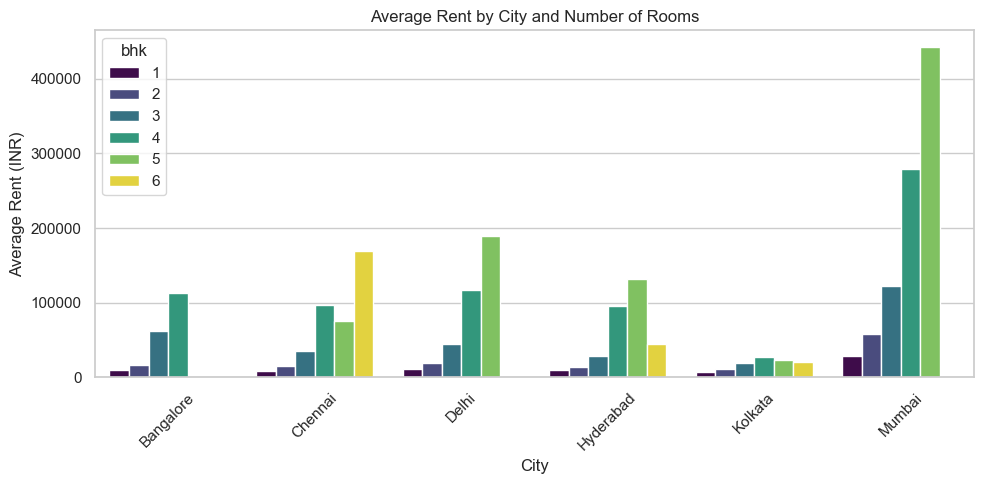

In [14]:
sns.set(style="whitegrid")
plt.figure(figsize=(10, 5))
sns.barplot(
    data=avg_rent_by_bhk_city,
    x="city",
    y="avg_rent",
    hue="bhk",
    palette="viridis"  # Puedes probar 'viridis', 'mako', 'rocket', etc.
)
plt.title("Average Rent by City and Number of Rooms")
plt.ylabel("Average Rent (INR)")
plt.xlabel("City")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [15]:
print(df_raw.sort_values(by='rent', ascending=False).head())

       posted on  bhk     rent  size         floor    area type  \
1837  2022-06-08    3  3500000  2500    4 out of 4  Carpet Area   
1001  2022-06-01    4  1200000  5000   4 out of 15  Carpet Area   
827   2022-05-18    4  1000000  3064  18 out of 45  Carpet Area   
1329  2022-06-23    4   850000  3200    2 out of 4  Carpet Area   
1459  2022-06-27    4   700000  3200  24 out of 24  Carpet Area   

                area locality       city furnishing status  tenant preferred  \
1837             Marathahalli  Bangalore    Semi-Furnished         Bachelors   
1001                     Juhu     Mumbai    Semi-Furnished  Bachelors/Family   
827     Raheja Artesia, Worli     Mumbai    Semi-Furnished            Family   
1329             Breach Candy     Mumbai         Furnished  Bachelors/Family   
1459  Lady Ratan Tower, Worli     Mumbai         Furnished  Bachelors/Family   

      bathroom point of contact  
1837         3    Contact Agent  
1001         4    Contact Agent  
827          4

C:\Users\franc\AppData\Local\Temp\ipykernel_13192\2641019721.py:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend().remove()


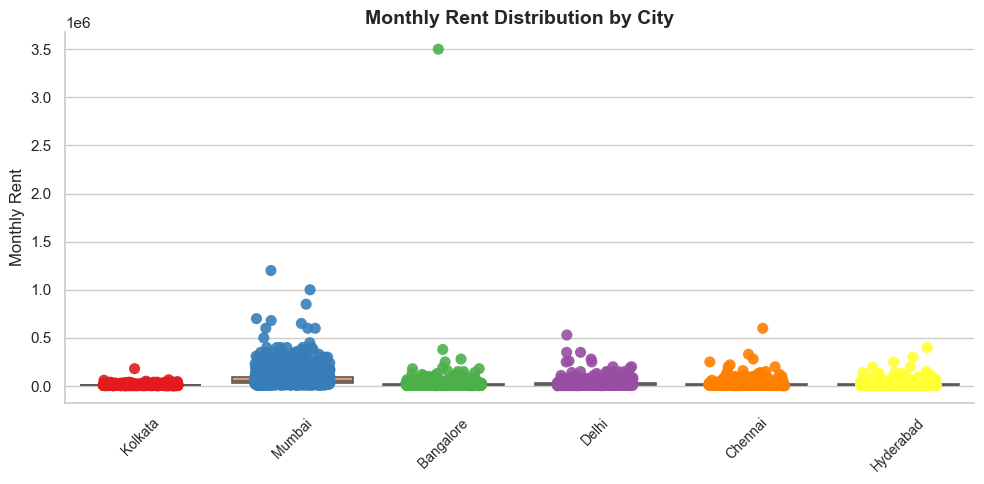

In [16]:
warnings.filterwarnings("ignore", category=FutureWarning)

plt.figure(figsize=(10, 5))
sns.boxplot(x='city', y='rent', data=df_raw, showfliers=False, palette='Set2', linewidth=1.2)
sns.stripplot(x='city', y='rent', data=df_raw, hue='city', dodge=False, palette='Set1',
    jitter=0.25, size=8, alpha=0.9)
plt.legend().remove()
plt.xticks(rotation=45, fontsize=10)
plt.title('Monthly Rent Distribution by City', fontsize=14, weight='bold')
plt.ylabel('Monthly Rent', fontsize=12)
plt.xlabel('')
sns.despine()
plt.tight_layout()
plt.show()

- El análisis de las **5 propiedades con los alquileres más altos** mostró que todas se encuentran en **Mumbai** y representan propiedades de lujo con parámetros no convencionales. Por ejemplo, las propiedades con menor superficie pueden ser más caras debido a un piso alto, posiblemente áticos u otros tipos de viviendas de lujo. Estos casos pueden **distorsionar el aprendizaje del modelo**, especialmente la regresión lineal, y requieren un filtrado o un enfoque independiente.

- Este gráfico solo muestra el valor atípico para la ciudad de **Bangalore**, necesitamos encontrarlo y verificarlo.

> **Conclusión:**  
> Es recomendable considerar **Mumbai por separado** al construir modelos para evitar distorsionar la tendencia general del mercado de alquiler.

In [17]:
df_raw.rent.sort_values(ascending=False).head(5)

1837    3500000
1001    1200000
827     1000000
1329     850000
1459     700000
Name: rent, dtype: int64

In [18]:
df_raw.loc[[1837]]

,posted on,bhk,rent,size,floor,area type,area locality,city,furnishing status,tenant preferred,bathroom,point of contact
1837,2022-06-08,3,3500000,2500,4 out of 4,Carpet Area,Marathahalli,Bangalore,Semi-Furnished,Bachelors,3,Contact Agent


Un análisis detallado muestra que esta vivienda no es líder en cuanto a superficie ni número de habitaciones, por lo que un coste tan anormalmente alto probablemente se deba a un **error**.

**Acciones tomadas:**
- Elimino esta línea del conjunto de datos.
- Corrijo los valores máximos de alquiler, limitándolos hasta el **percentil 99**.

Esto permite evitar distorsiones en el análisis y mejora la calidad de los datos para el modelado.

In [19]:
df_raw =df_raw.drop(index=[1837])

# Limitar los valores máximos de alquiler al percentil 99
upper_limit = df_raw['rent'].quantile(0.99)
df_raw = df_raw[df_raw['rent'] <= upper_limit]

Se filtra el **1% superior de los alquileres** para mejorar la estabilidad de la predicción.


> **Advertencia:**  
> La principal vulnerabilidad es la posible pérdida de precisión para las viviendas de lujo, que ahora el modelo ignora.  
> Para predecir el coste de las viviendas de lujo, recomiendo construir un **modelo independiente** con un conjunto de datos diferente solo para este segmento.

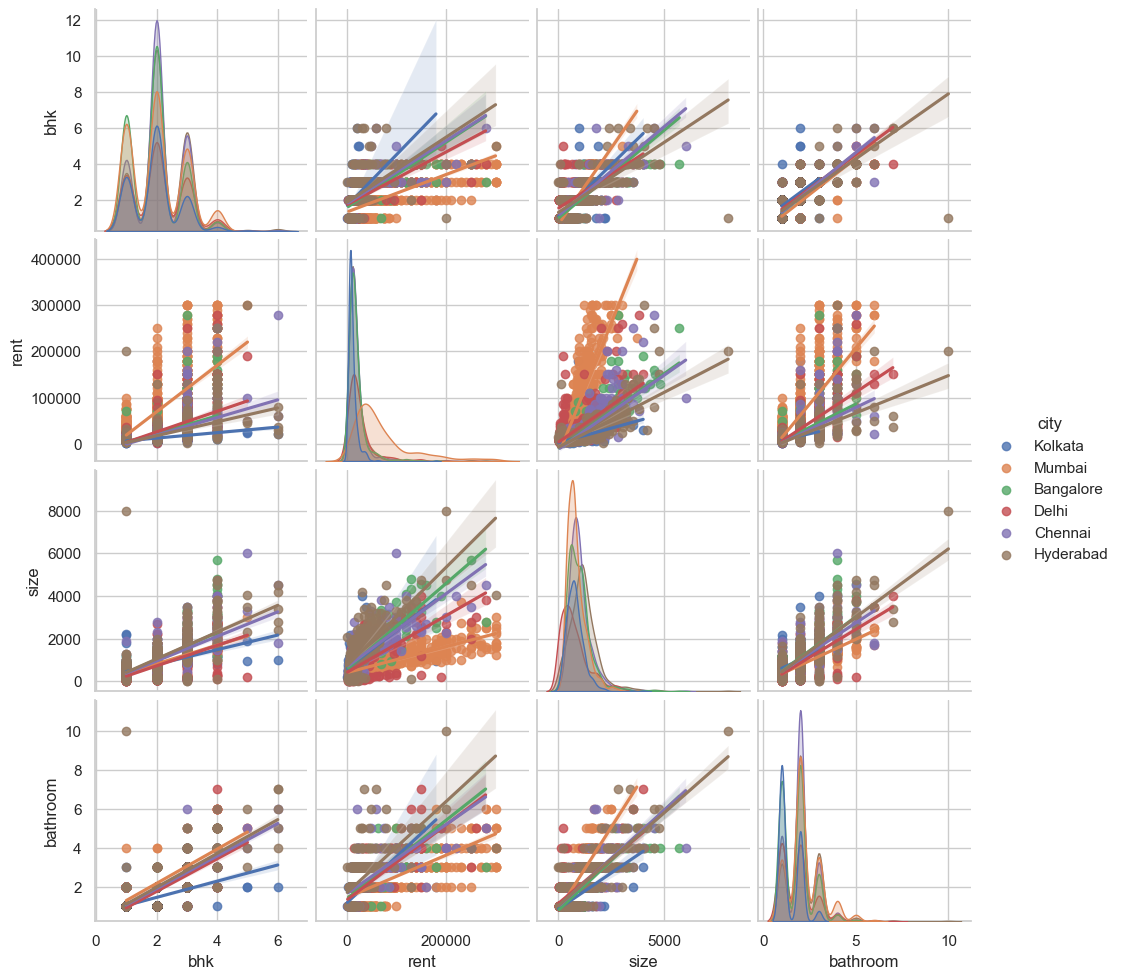

In [20]:
warnings.filterwarnings("ignore")
sns.pairplot(df_raw[['bhk', 'rent', 'size', 'furnishing status', 'bathroom', 'city']], hue='city', kind='reg')

**Análisis de los datos residuales:**  
Se detecta un valor atípico en las variables **bath** y **size** para la ciudad de **Hyderabad**.  
Es necesario investigar si se trata de un error de captura de datos.

In [21]:
df_raw.bathroom.sort_values().tail(10)

1160     6
4648     6
4543     6
1093     6
2845     6
2849     6
4518     7
2846     7
4350     7
4185    10
Name: bathroom, dtype: int64

In [22]:
df_raw.loc[[4185]]

,posted on,bhk,rent,size,floor,area type,area locality,city,furnishing status,tenant preferred,bathroom,point of contact
4185,2022-06-06,1,200000,8000,Ground out of 4,Super Area,"Beeramguda, Ramachandra Puram, NH 9",Hyderabad,Unfurnished,Bachelors/Family,10,Contact Owner


Esta vivienda cuenta con una **gran superficie** y **varios baños**, lo que justifica el alto coste. Pero, el valor de **bhk** aparece como 1, lo cual probablemente se deba a un error en el registro de este campo ya que no tiene logica.

> **Nota:**  
> Es importante revisar y corregir estos posibles errores en los datos antes de continuar con el análisis, ya que pueden afectar la calidad de los resultados.

Las columnas **Post-On** y **area locality** no aportaron valor cualitativo al análisis.  
La columna **locality** contiene más de **2000 valores únicos**, lo que dificulta su conversión a variables numéricas y puede generar problemas de dimensionalidad.  
Por estas razones, decidí **eliminar estas columnas** del conjunto de datos.

In [23]:
df_raw = df_raw.drop(index=[4185])
df_raw = df_raw.drop(columns=['posted on', 'area locality'])

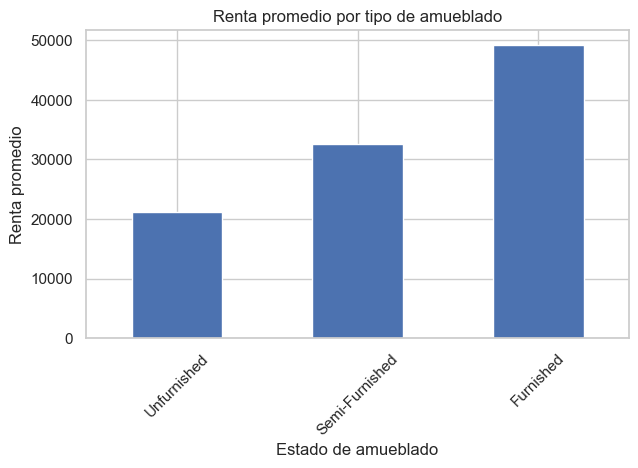

In [24]:
grouped = df_raw.groupby('furnishing status')['rent'].mean().reindex(['Unfurnished', 'Semi-Furnished', 'Furnished'])

grouped.plot(kind='bar', figsize=(7,4))
plt.title('Renta promedio por tipo de amueblado')
plt.ylabel('Renta promedio')
plt.xlabel('Estado de amueblado')
plt.xticks(rotation=45)
plt.show()

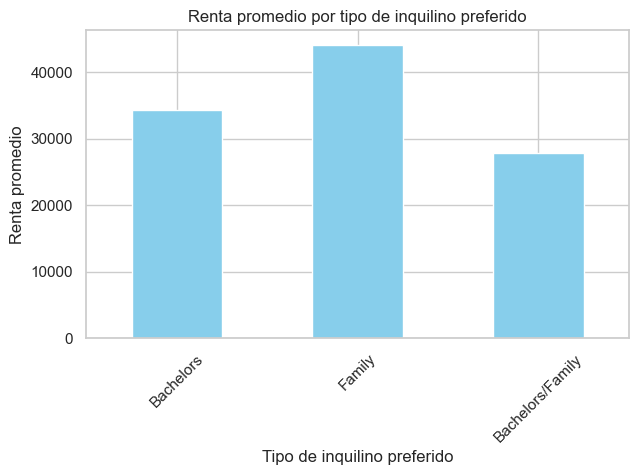

In [25]:
grouped = df_raw.groupby('tenant preferred')['rent'].mean().reindex(['Bachelors', 'Family', 'Bachelors/Family'])

grouped.plot(kind='bar', figsize=(7,4), color='skyblue')
plt.title('Renta promedio por tipo de inquilino preferido')
plt.ylabel('Renta promedio')
plt.xlabel('Tipo de inquilino preferido')
plt.xticks(rotation=45)
plt.show()

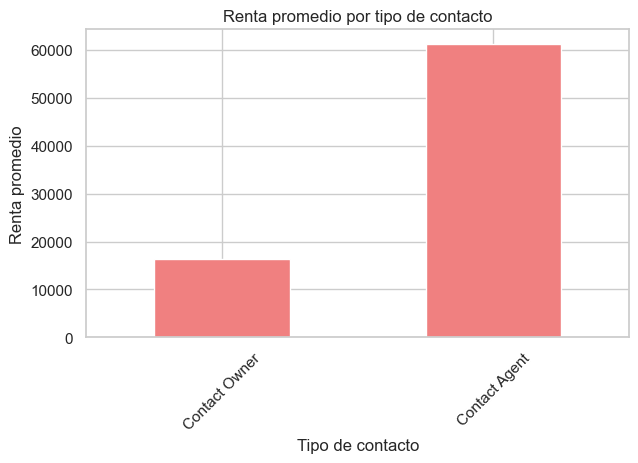

In [26]:
grouped = df_raw.groupby('point of contact')['rent'].mean().reindex(['Contact Owner', 'Contact Agent'])

grouped.plot(kind='bar', figsize=(7,4), color='lightcoral')
plt.title('Renta promedio por tipo de contacto')
plt.ylabel('Renta promedio')
plt.xlabel('Tipo de contacto')
plt.xticks(rotation=45)
plt.show()

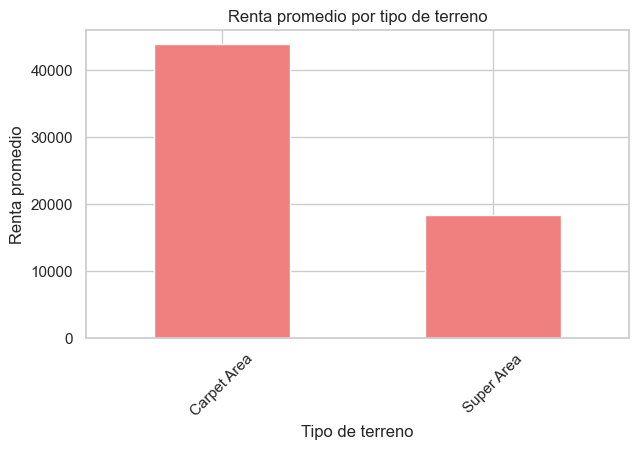

In [27]:
grouped = df_raw.groupby('area type')['rent'].mean()

grouped.plot(kind='bar', figsize=(7,4), color='lightcoral')
plt.title('Renta promedio por tipo de terreno')
plt.ylabel('Renta promedio')
plt.xlabel('Tipo de terreno')
plt.xticks(rotation=45)
plt.show()

- para la variable `area_type`,`tenant_prefered` y `point_of_contact` realizaremos un **one-hot-encoding** ya que solo tenemos dos datos de cada una y el modelo entrenaria mejor aunque se vea coo las medias auentan progresivamente. 
- para la variable `furnish_status`establecemos un **ordinal encoding** ya que podemos ver que teneoms una ordinalidad unfurnised>semi-furnished>furnished y la renta media aunmente segun pasamos de un estado a otro. 

### Comprobacion de la distribucion del target 


Text(0.5, 1.0, 'Distribución de renta')

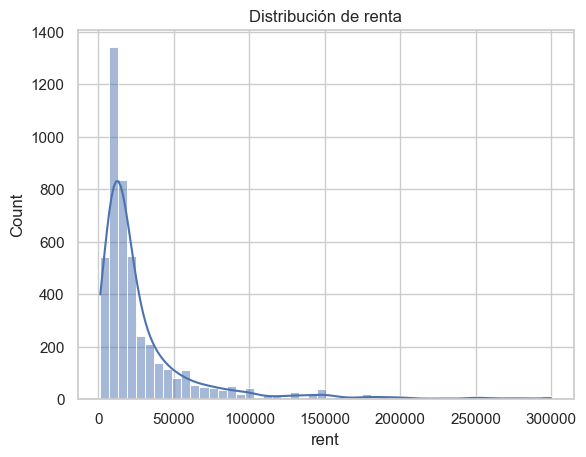

In [28]:
sns.histplot(df_raw['rent'], bins=50, kde=True)
plt.title("Distribución de renta")

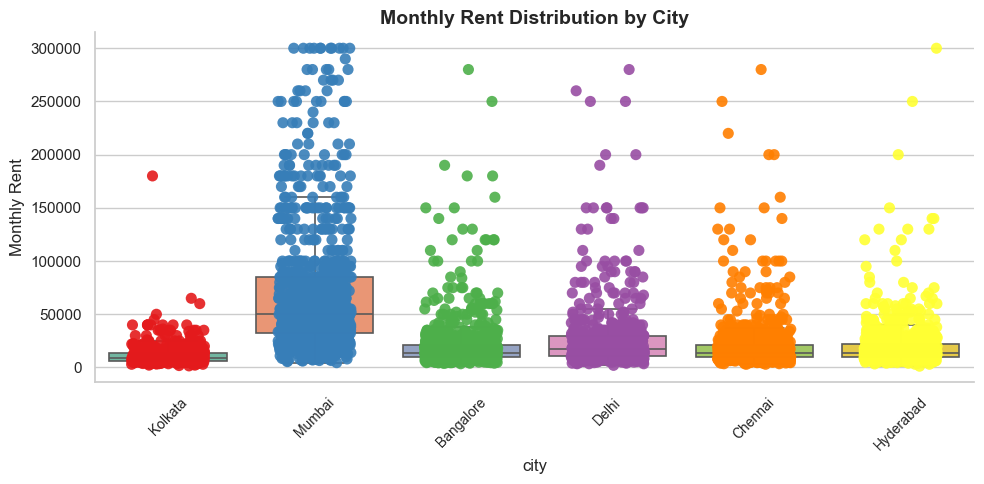

In [29]:
#boxplot para ver la distribución de la renta
plt.figure(figsize=(10, 5))
sns.boxplot(x='city', y='rent', data=df_raw, showfliers=False, palette='Set2', linewidth=1.2)
sns.stripplot(x='city', y='rent', data=df_raw, hue='city', dodge=False, palette='Set1',
    jitter=0.25, size=8, alpha=0.9)
plt.legend().remove()
plt.xticks(rotation=45, fontsize=10)
plt.title('Monthly Rent Distribution by City', fontsize=14, weight='bold')
plt.ylabel('Monthly Rent', fontsize=12)
sns.despine()
plt.tight_layout()
plt.show()




- El ultimo grafico reafirma la conclusion de que en Bombay los precios son mucho mas alto, posiblemente por la vivienda de lujo por lo que separaremos los modelos para nos sesgar el resto de ciudaddes.  

#### Normalizacion logaritmica de la variable **rent**

In [30]:

rent_skew_value = skew(df_raw['rent'])
print(f"Skewness: {rent_skew_value:.2f}")

Skewness: 3.47


In [31]:
df_raw['log_rent'] = np.log1p(df_raw['rent'])



In [32]:
#comparar la distribución original y la logarítmica
print("Comparación de la distribución original y logarítmica:")
print("skewness original: ", skew(df_raw['rent']))
print("skewness logarítmica: ", skew(df_raw['log_rent']))


Comparación de la distribución original y logarítmica:
skewness original:  3.469737390736441
skewness logarítmica:  0.7384210978806498


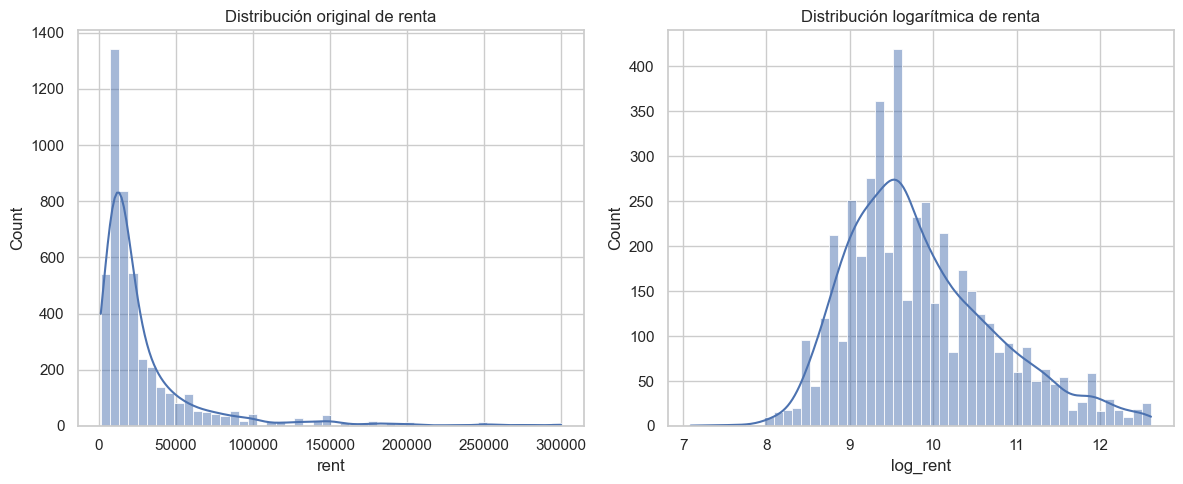

In [33]:
#Representación gráfica de la distribución original y logarítmica

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.histplot(df_raw['rent'], bins=50, kde=True, ax=axes[0])
axes[0].set_title('Distribución original de renta')

sns.histplot(df_raw['log_rent'], bins=50, kde=True, ax=axes[1])
axes[1].set_title('Distribución logarítmica de renta')

plt.tight_layout()
plt.show()


- al ver como la distribucion de la renta tiene una cola mas larga y no tiene una distribucion normal, tendemos a normalizarla con el logaritmo para posteriormente comparar los resultados de ambos modelos y elegir el que mejor rendimiento tenga .

Text(0.5, 1.0, 'Distribución de tamaño')

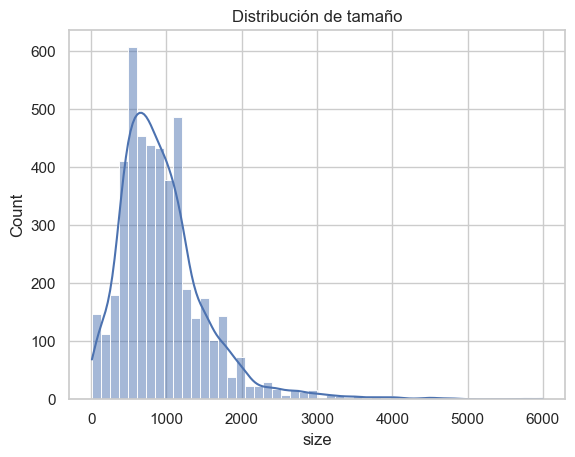

In [34]:
sns.histplot(df_raw['size'], bins=50, kde=True)
plt.title("Distribución de tamaño")

In [35]:
size_skew_value = skew(df_raw['size'])
print(f"Skewness: {size_skew_value:.2f}")

Skewness: 1.94


In [36]:
df_raw['log_size'] = np.log1p(df_raw['size'])

In [37]:
df_raw.head()

,bhk,rent,size,floor,area type,city,furnishing status,tenant preferred,bathroom,point of contact,log_rent,log_size
0,2,10000,1100,Ground out of 2,Super Area,Kolkata,Unfurnished,Bachelors/Family,2,Contact Owner,9.210440,7.003974
1,2,20000,800,1 out of 3,Super Area,Kolkata,Semi-Furnished,Bachelors/Family,1,Contact Owner,9.903538,6.685861
2,2,17000,1000,1 out of 3,Super Area,Kolkata,Semi-Furnished,Bachelors/Family,1,Contact Owner,9.741027,6.908755
3,2,10000,800,1 out of 2,Super Area,Kolkata,Unfurnished,Bachelors/Family,1,Contact Owner,9.210440,6.685861
4,2,7500,850,1 out of 2,Carpet Area,Kolkata,Unfurnished,Bachelors,1,Contact Owner,8.922792,6.746412


In [38]:
#comparar la distribución original y la logarítmica
print("Comparación de la distribución original y logarítmica:")
print("skewness original: ", skew(df_raw['size']))
print("skewness logarítmica: ", skew(df_raw['log_size']))

Comparación de la distribución original y logarítmica:
skewness original:  1.9428886775007865
skewness logarítmica:  -1.1703081883283564


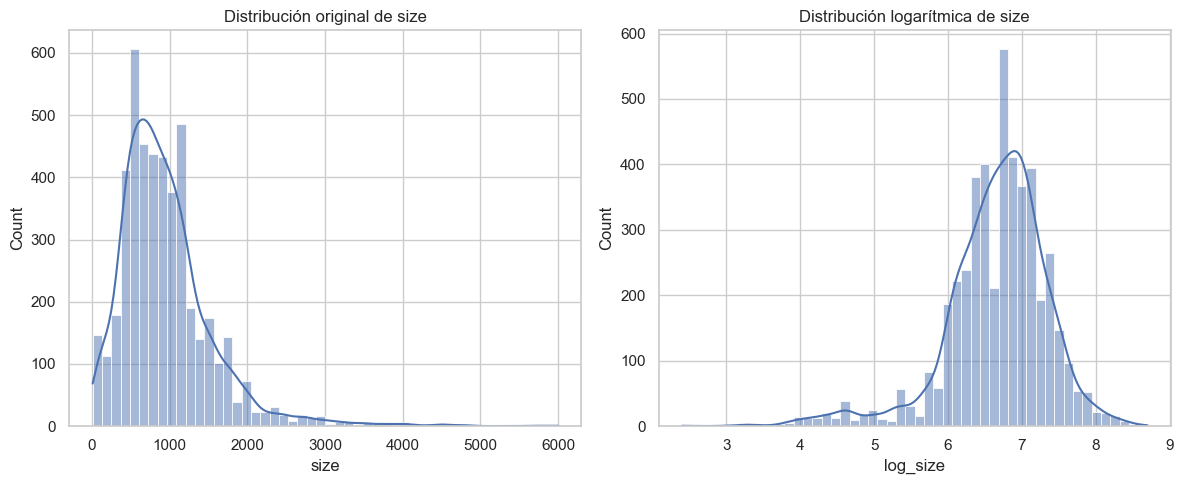

In [39]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.histplot(df_raw['size'], bins=50, kde=True, ax=axes[0])
axes[0].set_title('Distribución original de size')

sns.histplot(df_raw['log_size'], bins=50, kde=True, ax=axes[1])
axes[1].set_title('Distribución logarítmica de size')

plt.tight_layout()
plt.show()

## 2. Feature Ingeneering

#### Ingeniería de variables: características de piso

Se han creado nuevas variables a partir de la columna original **floor** para enriquecer el análisis y el modelado:

- **floor_number**: Número de piso en el que se encuentra la vivienda.
- **total_floors**: Número total de pisos del edificio.
- **is_ground_floor**: Indicador binario (0/1) si la vivienda está en planta baja.
- **is_top_floor**: Indicador binario (0/1) si la vivienda está en la última planta.
- **floor_ratio**: Proporción del piso respecto al total de pisos (`floor_number / total_floors`).

Estas variables permiten capturar el efecto de la ubicación vertical de la vivienda en el edificio, lo cual puede influir en el precio del alquiler y en las preferencias de los inquilinos.


In [40]:
df_raw['floor'].unique()

array(['Ground out of 2', '1 out of 3', '1 out of 2', 'Ground out of 1',
       'Ground out of 4', '1 out of 4', '1 out of 1', 'Ground out of 3',
       '2 out of 3', '4 out of 5', '2 out of 2', '2 out of 5',
       '4 out of 14', '3 out of 3', '5 out of 5', '4 out of 4',
       '7 out of 8', '2 out of 4', '3 out of 4', '1 out of 5',
       '8 out of 5', 'Ground out of 6', '2 out of 1',
       'Upper Basement out of 4', 'Ground out of 5', '3 out of 5',
       '11 out of 19', '5 out of 10', '11 out of 14',
       'Lower Basement out of 2', '2 out of 7', '4 out of 10',
       '7 out of 10', '2 out of 13', '6 out of 7', '4 out of 7',
       '14 out of 14', '43 out of 78', '2 out of 8', '13 out of 18',
       '5 out of 12', '18 out of 24', '3 out of 7', '11 out of 21',
       '7 out of 19', '14 out of 23', '9 out of 20',
       'Upper Basement out of 9', '19 out of 24', '3 out of 21',
       '1 out of 22', '8 out of 8', '6 out of 12', '4 out of 58',
       'Upper Basement out of 16', '60 o

In [41]:
def parse_floor(value):
    if pd.isnull(value):
        return np.nan, np.nan
    value = value.strip()
    if 'Ground' in value:
        total = int(value.split('out of')[1].strip()) if 'out of' in value else np.nan
        return 0, total
    elif 'Upper Basement' in value:
        total = int(value.split('out of')[1].strip())
        return -1, total
    elif 'Lower Basement' in value:
        total = int(value.split('out of')[1].strip())
        return -2, total
    elif 'out of' in value:
        parts = value.split('out of')
        floor = int(parts[0].strip())
        total = int(parts[1].strip())
        return floor, total
    elif value.isdigit():
        return int(value), np.nan
    else:
        return np.nan, np.nan

# Crear columnas 'floor_number' y 'total_floors' a partir de la columna 'Floor'
df_raw[['floor_number', 'total_floors']] = df_raw['floor'].apply(lambda x: pd.Series(parse_floor(x)))

In [42]:
df_raw.head(5)


,bhk,rent,size,floor,area type,city,furnishing status,tenant preferred,bathroom,point of contact,log_rent,log_size,floor_number,total_floors
0,2,10000,1100,Ground out of 2,Super Area,Kolkata,Unfurnished,Bachelors/Family,2,Contact Owner,9.210440,7.003974,0.0,2.0
1,2,20000,800,1 out of 3,Super Area,Kolkata,Semi-Furnished,Bachelors/Family,1,Contact Owner,9.903538,6.685861,1.0,3.0
2,2,17000,1000,1 out of 3,Super Area,Kolkata,Semi-Furnished,Bachelors/Family,1,Contact Owner,9.741027,6.908755,1.0,3.0
3,2,10000,800,1 out of 2,Super Area,Kolkata,Unfurnished,Bachelors/Family,1,Contact Owner,9.210440,6.685861,1.0,2.0
4,2,7500,850,1 out of 2,Carpet Area,Kolkata,Unfurnished,Bachelors,1,Contact Owner,8.922792,6.746412,1.0,2.0


In [43]:
print(df_raw['total_floors'].isnull().sum())
#eliminar nulos si es necesario
df_raw = df_raw.dropna(subset=['total_floors'])

4


In [44]:

def add_floor_features(df):
    """
    Añade columnas derivadas de la información de pisos:
    - is_ground_floor
    - is_top_floor
    - floor_ratio
    
    Requiere que el DataFrame tenga las columnas:
    - 'floor_number'
    - 'total_floors'
    
    Devuelve el DataFrame con las nuevas columnas añadidas.
    """
    
    # Asegurar tipos numéricos
    df['floor_number'] = pd.to_numeric(df['floor_number'], errors='coerce')
    df['total_floors'] = pd.to_numeric(df['total_floors'], errors='coerce')
    
    # Planta baja
    df['is_ground_floor'] = (df['floor_number'] == 0).astype(int)
    
    # Última planta
    df['is_top_floor'] = (df['floor_number'] == df['total_floors']).astype(int)
    
    # Proporción de piso respecto al total
    df['floor_ratio'] = np.where(
        (df['floor_number'].notna()) & (df['total_floors'] > 0),
        np.round(df['floor_number'] / df['total_floors'], 3),
        np.nan
    )
    
    return df


In [45]:
df_raw = add_floor_features(df_raw)

In [46]:
#como ya tenemos codificadas las columans de piso, podemos eliminar la columna original
df_raw = df_raw.drop(columns=['floor'])

In [47]:
df_raw.head(5)


,bhk,rent,size,area type,city,furnishing status,tenant preferred,bathroom,point of contact,log_rent,log_size,floor_number,total_floors,is_ground_floor,is_top_floor,floor_ratio
0,2,10000,1100,Super Area,Kolkata,Unfurnished,Bachelors/Family,2,Contact Owner,9.210440,7.003974,0.0,2.0,1,0,0.000
1,2,20000,800,Super Area,Kolkata,Semi-Furnished,Bachelors/Family,1,Contact Owner,9.903538,6.685861,1.0,3.0,0,0,0.333
2,2,17000,1000,Super Area,Kolkata,Semi-Furnished,Bachelors/Family,1,Contact Owner,9.741027,6.908755,1.0,3.0,0,0,0.333
3,2,10000,800,Super Area,Kolkata,Unfurnished,Bachelors/Family,1,Contact Owner,9.210440,6.685861,1.0,2.0,0,0,0.500
4,2,7500,850,Carpet Area,Kolkata,Unfurnished,Bachelors,1,Contact Owner,8.922792,6.746412,1.0,2.0,0,0,0.500


In [48]:
df_raw.groupby('is_ground_floor')['rent'].mean()
df_raw.groupby('is_top_floor')['rent'].mean()

is_top_floor
0    31425.621075
1    23409.957404
Name: rent, dtype: float64

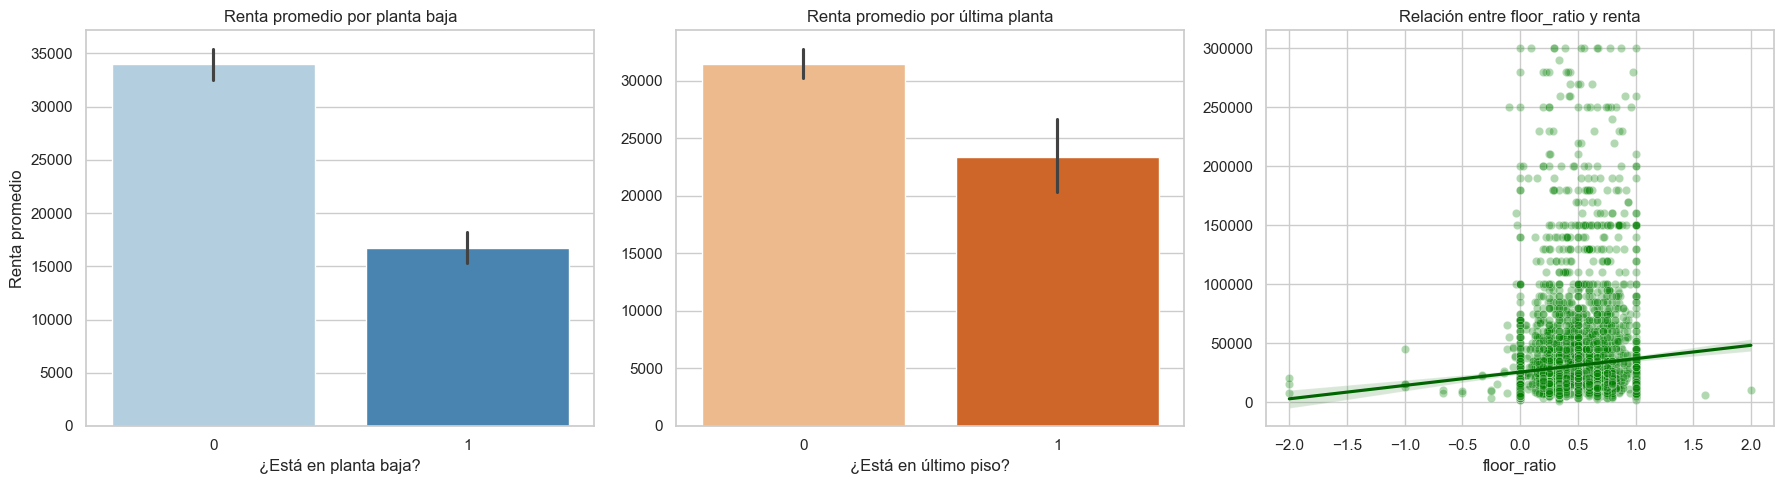

In [49]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Gráfico 1: Renta promedio según is_ground_floor
sns.barplot(
    x='is_ground_floor',
    y='rent',
    data=df_raw,
    ax=axes[0],
    palette='Blues'
)
axes[0].set_title('Renta promedio por planta baja')
axes[0].set_xlabel('¿Está en planta baja?')
axes[0].set_ylabel('Renta promedio')

# Gráfico 2: Renta promedio según is_top_floor
sns.barplot(
    x='is_top_floor',
    y='rent',
    data=df_raw,
    ax=axes[1],
    palette='Oranges'
)
axes[1].set_title('Renta promedio por última planta')
axes[1].set_xlabel('¿Está en último piso?')
axes[1].set_ylabel('')

# Gráfico 3: Relación entre floor_ratio y renta
sns.scatterplot(
    x='floor_ratio',
    y='rent',
    data=df_raw,
    ax=axes[2],
    alpha=0.3,
    color='green'
)
sns.regplot(
    x='floor_ratio',
    y='rent',
    data=df_raw,
    ax=axes[2],
    scatter=False,
    color='darkgreen'
)
axes[2].set_title('Relación entre floor_ratio y renta')
axes[2].set_xlabel('floor_ratio')
axes[2].set_ylabel('')

plt.tight_layout()
plt.show()

-  Vemos como las rentas de los pisos que si estan en planta baja (`is_ground_floor` = 1) tienen una media de renta mucho menor que los que no estan en planta baja (`is_ground_floo`= 1) asi como ocurre con los que estan en un atico/ultimo piso (`is_top_floor`=1) tienen una renta menor que las que estan en pisos intermedios. 

- Las variables `is_ground_floor` y `is_top_floor` son predictores muy potentes debido a las claras diferencias en las rentas promedio. La variable continua floor_ratio es un predictor más débil pero útil, que captura una tendencia sutil. En conjunto, estos gráficos confirman que la ubicación vertical del piso es fundamental para determinar su precio de alquiler en el dataset.

- Como podemos ver algunos datos de la variable `floor_ratio` son valores negativos por lo que puede sesgar nuestro modelo, a continuacion veremos las cantidad de datos en relacion del dataset para ver si nuestro modelo se puede ver sesgado de manera negativa y con ello influir negativamente en las predicciones del modelo. 

In [50]:
total_filas = df_raw.shape[0]

negativos = df_raw[df_raw['floor_ratio'] < 0].shape[0]

porcentaje = round((negativos / total_filas) * 100,4)
print(f"Porcentaje de valores negativos totales",porcentaje,"%")

Porcentaje de valores negativos totales 0.6813 %


- Al ser un porcentaje tan pequeño, consideramos que lo mas correcto para que no influya en el desempeño del modelo así como considerar que tan pocos valores no serviran a nuestro modelo en el entrenamiento, procedemos a eliminar esos datos. 

In [51]:
df_raw = df_raw[df_raw['floor_ratio'] >= 0]

#### Codificación de la variable `furnishing status`

La variable **furnishing status** representa el nivel de amueblamiento de la vivienda y se ha transformado en una variable ordinal para facilitar el modelado:

- **Unfurnished** → 0
- **Semi-Furnished** → 1
- **Furnished** → 2

Esta codificación permite que los algoritmos de machine learning interpreten correctamente el grado de amueblamiento y su posible impacto en el precio del alquiler.

In [52]:

def encode_furnishing_status(df, column='furnishing status'):
    """
    Codifica la columna 'Furnishing Status' como una variable ordinal:
    - Unfurnished = 0
    - Semi-Furnished = 1
    - Furnished = 2
    
    Si encuentra valores no esperados, los marca como NaN.
    Devuelve el DataFrame con la nueva columna 'furnishing_encoded'.
    """
    
    mapping = {
        'Unfurnished': 0,
        'Semi-Furnished': 1,
        'Furnished': 2
    }
    
    df['furnishing_encoded'] = df[column].map(mapping)
    
    return df


In [53]:
df_raw = encode_furnishing_status(df_raw)

In [54]:
df_raw.head(5)

,bhk,rent,size,area type,city,furnishing status,tenant preferred,bathroom,point of contact,log_rent,log_size,floor_number,total_floors,is_ground_floor,is_top_floor,floor_ratio,furnishing_encoded
0,2,10000,1100,Super Area,Kolkata,Unfurnished,Bachelors/Family,2,Contact Owner,9.210440,7.003974,0.0,2.0,1,0,0.000,0
1,2,20000,800,Super Area,Kolkata,Semi-Furnished,Bachelors/Family,1,Contact Owner,9.903538,6.685861,1.0,3.0,0,0,0.333,1
2,2,17000,1000,Super Area,Kolkata,Semi-Furnished,Bachelors/Family,1,Contact Owner,9.741027,6.908755,1.0,3.0,0,0,0.333,1
3,2,10000,800,Super Area,Kolkata,Unfurnished,Bachelors/Family,1,Contact Owner,9.210440,6.685861,1.0,2.0,0,0,0.500,0
4,2,7500,850,Carpet Area,Kolkata,Unfurnished,Bachelors,1,Contact Owner,8.922792,6.746412,1.0,2.0,0,0,0.500,0


In [55]:
df_raw = df_raw.drop(columns=['furnishing status'])

In [56]:
df_raw.head()

,bhk,rent,size,area type,city,tenant preferred,bathroom,point of contact,log_rent,log_size,floor_number,total_floors,is_ground_floor,is_top_floor,floor_ratio,furnishing_encoded
0,2,10000,1100,Super Area,Kolkata,Bachelors/Family,2,Contact Owner,9.210440,7.003974,0.0,2.0,1,0,0.000,0
1,2,20000,800,Super Area,Kolkata,Bachelors/Family,1,Contact Owner,9.903538,6.685861,1.0,3.0,0,0,0.333,1
2,2,17000,1000,Super Area,Kolkata,Bachelors/Family,1,Contact Owner,9.741027,6.908755,1.0,3.0,0,0,0.333,1
3,2,10000,800,Super Area,Kolkata,Bachelors/Family,1,Contact Owner,9.210440,6.685861,1.0,2.0,0,0,0.500,0
4,2,7500,850,Carpet Area,Kolkata,Bachelors,1,Contact Owner,8.922792,6.746412,1.0,2.0,0,0,0.500,0


#### One Hot Encoding para las variables categoricas    

In [57]:
categorical_cols = ['area type', 'city', 'tenant preferred', 'point of contact']
df_encoded = pd.get_dummies(df_raw, columns=categorical_cols, drop_first=True)

In [58]:
print(df_encoded.head())

   bhk   rent  size  bathroom  log_rent  log_size  floor_number  total_floors  \
0    2  10000  1100         2  9.210440  7.003974           0.0           2.0   
1    2  20000   800         1  9.903538  6.685861           1.0           3.0   
2    2  17000  1000         1  9.741027  6.908755           1.0           3.0   
3    2  10000   800         1  9.210440  6.685861           1.0           2.0   
4    2   7500   850         1  8.922792  6.746412           1.0           2.0   

   is_ground_floor  is_top_floor  ...  furnishing_encoded  \
0                1             0  ...                   0   
1                0             0  ...                   1   
2                0             0  ...                   1   
3                0             0  ...                   0   
4                0             0  ...                   0   

   area type_Super Area  city_Chennai  city_Delhi  city_Hyderabad  \
0                  True         False       False           False   
1       

In [59]:
df_encoded.to_csv('../data/df_encoded.csv',index=False)

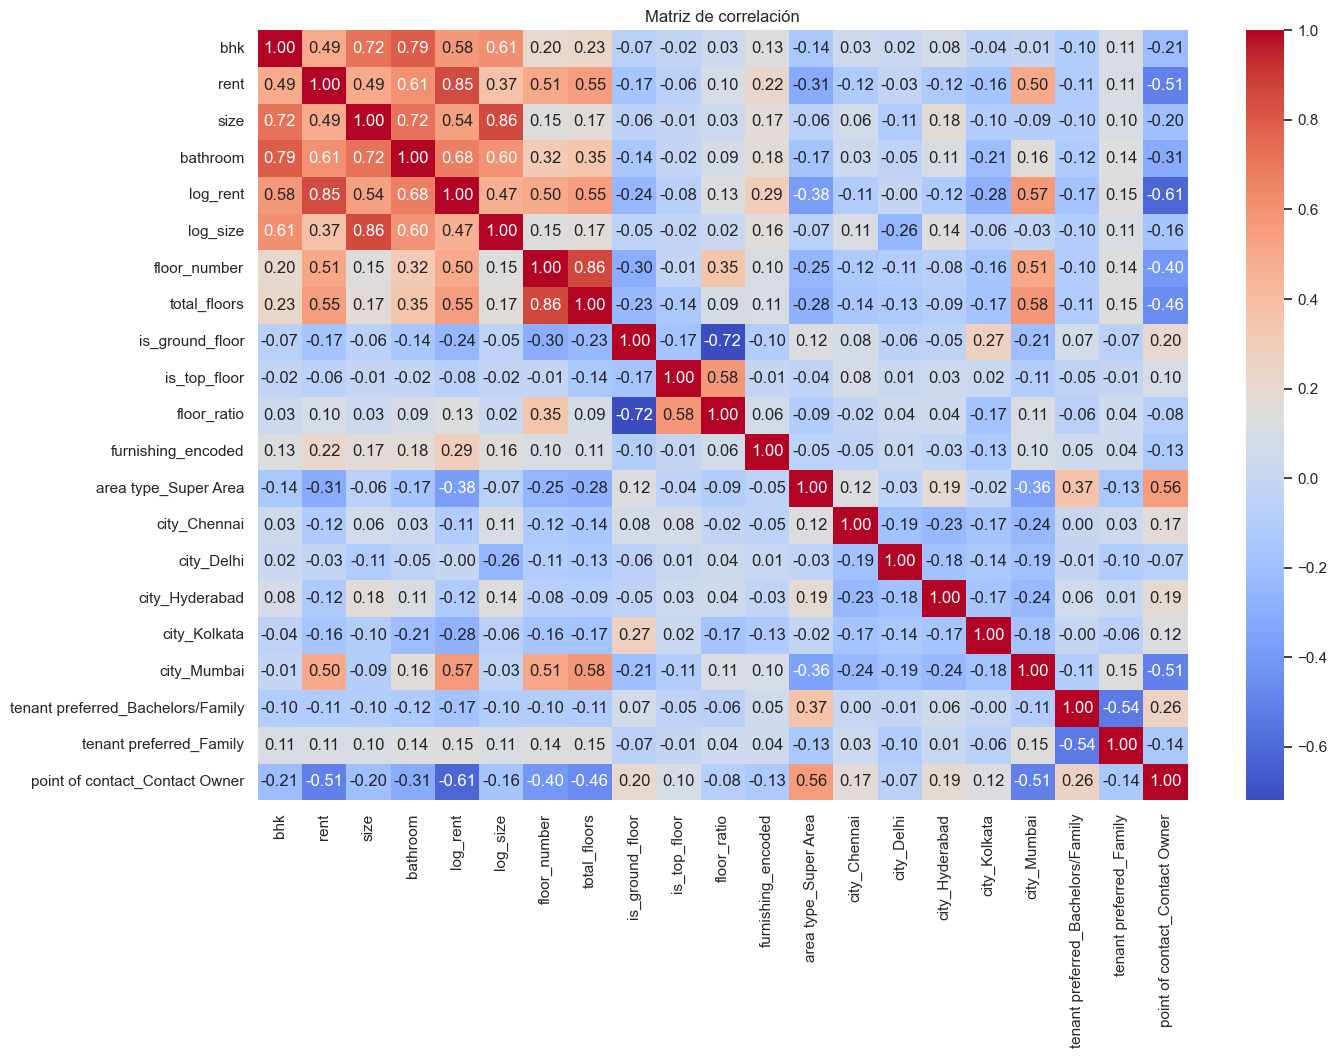

In [60]:
# Calcular la matriz de correlación
correlation_matrix = df_encoded.corr()
# hacer heatmap
plt.figure(figsize=(15,10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matriz de correlación')
plt.show()

# PCA
Se va a determinar cuáles son las variables que aportan mas para la predicción de la renta:

Ajuste realizado. Se excluyeron las siguientes columnas: ['log_size', 'log_rent']
Columnas utilizadas para el PCA: ['bhk', 'size', 'bathroom', 'floor_number', 'total_floors', 'is_ground_floor', 'is_top_floor', 'floor_ratio', 'furnishing_encoded', 'area type_Super Area', 'city_Chennai', 'city_Delhi', 'city_Hyderabad', 'city_Kolkata', 'city_Mumbai', 'tenant preferred_Bachelors/Family', 'tenant preferred_Family', 'point of contact_Contact Owner']

Gráfico de varianza acumulada ajustado guardado como 'cumulative_variance_adjusted.png'

Se analizarán los primeros 13 componentes (cubren >95% de la varianza).

Loadings de las variables en los primeros componentes principales (Ajustado):
                                        PC1       PC2       PC3       PC4       PC5       PC6       PC7       PC8       PC9      PC10      PC11      PC12      PC13
bhk                                0.268217  0.471531 -0.025633 -0.032293  0.149880  0.019763  0.144287 -0.094045  0.104211 -0.066820  0.106632  0.

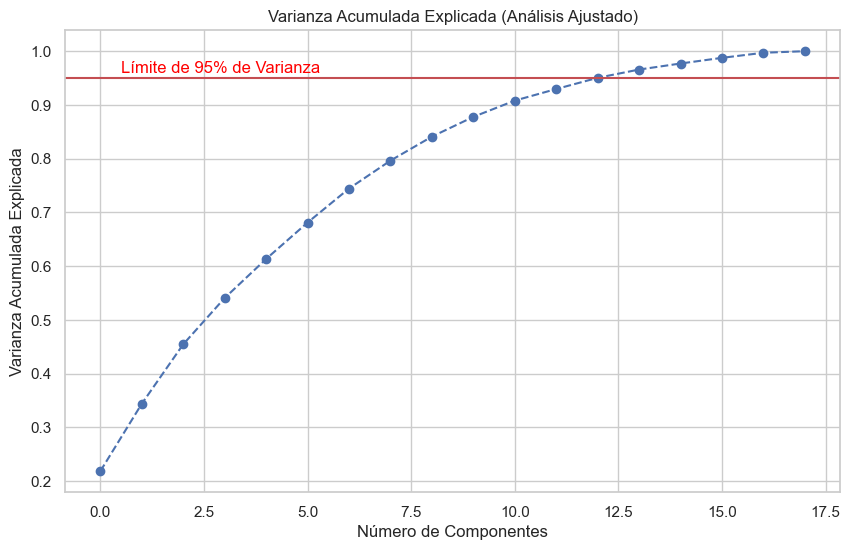

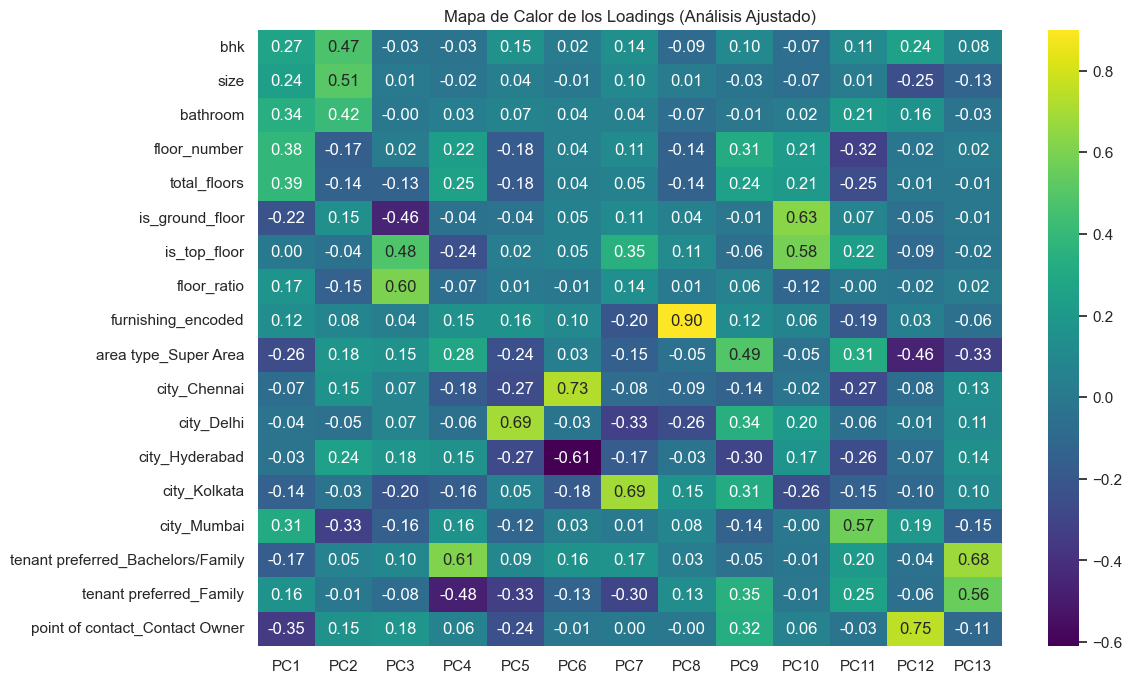

In [61]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Separar las variables predictoras (X) de la variable objetivo (y)
# Se asume que la columna objetivo se llama 'rent' en minúsculas como en el código original.
X = df_encoded.drop('rent', axis=1)
y = df_encoded['rent']


# 2. AJUSTE: Excluir 'log_size' y 'log_rent' para evitar multicolinealidad
# Se eliminan explícitamente las columnas transformadas para no incluirlas en el PCA.
columns_to_exclude = ['log_size', 'log_rent']
# Nos aseguramos de que solo se intenten eliminar las columnas que realmente existen en el DataFrame
existing_columns_to_exclude = [col for col in columns_to_exclude if col in X.columns]

if existing_columns_to_exclude:
    X = X.drop(columns=existing_columns_to_exclude)
    print(f"Ajuste realizado. Se excluyeron las siguientes columnas: {existing_columns_to_exclude}")
else:
    print("No se encontraron las columnas 'log_size' o 'log_rent' para excluir.")


# Guardamos los nombres de las columnas que sí se usarán en el análisis
feature_names = X.columns
print(f"Columnas utilizadas para el PCA: {feature_names.tolist()}")


# 3. Escalar los datos
# PCA es sensible a la escala de las variables, por lo que es fundamental estandarizarlas.
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


# 4. Aplicar PCA
# Creamos una instancia de PCA. Al no definir n_components, se calcularán todos los posibles.
pca = PCA()
X_pca = pca.fit_transform(X_scaled)


# 5. Determinar el número de componentes a mantener (Criterio de Varianza)
# Graficamos la varianza acumulada explicada por los componentes.
plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o', linestyle='--')
plt.title('Varianza Acumulada Explicada (Análisis Ajustado)')
plt.xlabel('Número de Componentes')
plt.ylabel('Varianza Acumulada Explicada')
plt.grid(True)
# Añadimos una línea en el 95% para ver cuántos componentes necesitamos para alcanzar ese umbral.
plt.axhline(y=0.95, color='r', linestyle='-')
plt.text(0.5, 0.96, 'Límite de 95% de Varianza', color = 'red', fontsize=12)
plt.savefig('cumulative_variance_adjusted.png')
print("\nGráfico de varianza acumulada ajustado guardado como 'cumulative_variance_adjusted.png'")


# 6. Analizar los "Loadings" de los componentes
# Los "loadings" nos dicen qué tanto peso tiene cada variable original en cada componente.

# Determinamos dinámicamente cuántos componentes analizar para llegar al 95% de varianza
try:
    n_components_to_analyze = (np.cumsum(pca.explained_variance_ratio_) < 0.95).sum() + 1
except:
    # Si solo hay un componente, se analiza ese.
    n_components_to_analyze = 1

print(f"\nSe analizarán los primeros {n_components_to_analyze} componentes (cubren >95% de la varianza).")


loadings = pd.DataFrame(
    pca.components_[:n_components_to_analyze].T, # Usamos la transpuesta para tener variables en filas
    columns=[f'PC{i+1}' for i in range(n_components_to_analyze)],
    index=feature_names
)

print("\nLoadings de las variables en los primeros componentes principales (Ajustado):")
print(loadings.to_string())


# Para visualizarlo mejor, podemos usar un mapa de calor
plt.figure(figsize=(12, 8))
sns.heatmap(loadings, annot=True, cmap='viridis', fmt='.2f')
plt.title('Mapa de Calor de los Loadings (Análisis Ajustado)')
plt.savefig('loadings_heatmap_adjusted.png')
print("\nMapa de calor de los loadings ajustado guardado como 'loadings_heatmap_adjusted.png'")


In [62]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics

# APLICAR PCA CON 13 COMPONENTES
# Basado en el análisis, establecemos n_components=13
n_components = 13
pca = PCA(n_components=n_components)

# Ajustamos PCA a los datos escalados y los transformamos
X_pca = pca.fit_transform(X_scaled)

# Creamos un nuevo DataFrame con los componentes principales
# Este será nuestro nuevo conjunto de características (features)
df_pca = pd.DataFrame(
    data=X_pca,
    columns=[f'Componente Principal {i+1}' for i in range(n_components)]
)

print("--- Nuevo DataFrame con 13 Componentes Principales ---")
print(df_pca.head())

# 4. ENTRENAR UN MODELO DE PREDICCIÓN CON LOS COMPONENTES
# Ahora usamos df_pca como nuestras 'X' para entrenar el modelo.

# Dividimos los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(df_pca, y, test_size=0.2, random_state=42)

--- Nuevo DataFrame con 13 Componentes Principales ---
   Componente Principal 1  Componente Principal 2  Componente Principal 3  \
0               -2.352015                0.924657               -2.232247   
1               -1.835481               -0.266755               -0.408393   
2               -1.755664               -0.097087               -0.406284   
3               -1.965854               -0.444336               -0.134928   
4               -1.036780               -0.882344               -0.647537   

   Componente Principal 4  Componente Principal 5  Componente Principal 6  \
0                0.011382               -0.097309               -0.495004   
1                0.294688                0.090964               -0.508345   
2                0.287719                0.103614               -0.510873   
3                0.011434               -0.121875               -0.660728   
4               -1.924572                0.161639               -1.066729   

   Componente Princ

In [60]:
df_pca.head(100)

,Componente Principal 1,Componente Principal 2,Componente Principal 3,Componente Principal 4,Componente Principal 5,Componente Principal 6,Componente Principal 7,Componente Principal 8,Componente Principal 9,Componente Principal 10,Componente Principal 11,Componente Principal 12,Componente Principal 13
0,-2.352015,0.924657,-2.232247,0.011382,-0.097309,-0.495004,2.303822,-0.322546,1.034617,0.026203,0.521748,-0.390114,0.011643
1,-1.835481,-0.266755,-0.408393,0.294688,0.090964,-0.508345,1.790956,0.927745,1.395436,-1.511366,-0.281766,-0.300342,0.063704
2,-1.755664,-0.097087,-0.406284,0.287719,0.103614,-0.510873,1.825568,0.931193,1.386181,-1.535196,-0.277676,-0.383728,0.020778
3,-1.965854,-0.444336,-0.134928,0.011434,-0.121875,-0.660728,2.155132,-0.370725,1.228818,-1.689659,0.023286,-0.350552,0.161462
4,-1.036780,-0.882344,-0.647537,-1.924572,0.161639,-1.066729,2.091153,-0.337119,0.362552,-1.553168,-1.056935,0.643457,-0.707594
...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,-1.969994,-1.807475,-0.407087,-0.486626,0.149078,-0.735860,2.193202,-0.171236,0.139895,-1.439026,-0.748263,0.485340,0.836541
96,-1.100435,0.679570,-0.353501,0.532919,0.431216,-0.317751,1.612245,2.169613,1.531848,-1.443291,-0.310758,-0.236562,-0.149275
97,-1.023026,-1.147885,0.068351,-0.237315,0.484285,-0.552263,2.265614,0.961282,0.636584,-1.420765,-1.067078,0.723024,0.820312
98,0.177923,1.402776,-0.674765,-3.028838,-0.970598,-1.353615,1.250444,-0.313021,2.741349,-1.884126,0.925665,0.156311,0.581570


## Conclusión del Análisis de Componentes Principales (PCA)
Tras analizar los resultados obtenidos, se concluye que el número óptimo de componentes principales a utilizar para el modelo de predicción es de 13.

Esta recomendación se fundamenta en el gráfico de "Varianza Acumulada Explicada". En dicho gráfico, se observa que es con 13 componentes cuando la varianza acumulada supera el umbral del 95%, lo que garantiza que se retiene la mayor parte de la información estructural de los datos, descartando el ruido y la redundancia menos significativa.

Adicionalmente, el análisis de los "loadings" a través del mapa de calor y la tabla de datos confirma que estos 13 componentes capturan de manera lógica las características más importantes de las viviendas, como sus dimensiones, ubicación y atributos específicos del piso.

## 3. Entrenamiento de modelos. 

- Entrenar diferentes modelos: 

    - Con y sin Mumbai 
    - Con y sin normalizaciones logaritmicas

    - Orden de modelos: 
        1) Ridge, evitamos multicolinaliedad. 
        2) RandomForestRegressor y XGboosRegressor 

    >*Comprobar rendimiento del MAE,RMSE y R2*

    - Elegir el que mejor rendimiento tenga: 

        - Ajustar hiperparametros.

    >*Comprobar rendimiento del MAE,RMSE y R2*


In [66]:
def evaluar_modelo_sin_log(modelo, X_test, y_test, nombre_modelo="Modelo"):
    inicio = time.time()
    
    y_pred = modelo.predict(X_test)
    
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    fin = time.time()
    tiempo = fin - inicio
    
    print(f"📊 Evaluación de {nombre_modelo}:")
    print(f"   RMSE: {rmse:.4f}")
    print(f"   MAE:  {mae:.4f}")
    print(f"   R²:   {r2:.4f}")
    print(f"   Tiempo de predicción: {tiempo:.2f} segundos\n")
    
    return {
        "modelo": nombre_modelo,
        "rmse": rmse,
        "mae": mae,
        "r2": r2,
        "tiempo_prediccion": tiempo
    }


In [67]:
def entrenar_y_evaluar_sin_log(X_train, X_test, y_train, y_test, sufijo=""):
    resultados = []
    
    # Ridge Regression
    ridge = Ridge()
    ridge.fit(X_train, y_train)
    resultados.append(evaluar_modelo_sin_log(ridge, X_test, y_test, f"Ridge {sufijo}"))
    
    # Random Forest
    rf = RandomForestRegressor(random_state=42)
    rf.fit(X_train, y_train)
    resultados.append(evaluar_modelo_sin_log(rf, X_test, y_test, f"Random Forest {sufijo}"))
    
    # XGBoost
    xgb_reg = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
    xgb_reg.fit(X_train, y_train)
    resultados.append(evaluar_modelo_sin_log(xgb_reg, X_test, y_test, f"XGBoost {sufijo}"))
    
    return resultados

In [68]:
def evaluar_modelo_con_log(modelo, X_test, y_test_log, nombre_modelo="Modelo"):
    y_pred_log = modelo.predict(X_test)
    # Convertir predicciones y target de log a escala original
    y_pred = np.exp(y_pred_log)
    y_test = np.exp(y_test_log)
    
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    print(f"📊 Evaluación de {nombre_modelo} (escala original tras revertir log):")
    print(f"   RMSE: {rmse:.4f}")
    print(f"   MAE:  {mae:.4f}")
    print(f"   R²:   {r2:.4f}\n")
    
    return {"modelo": nombre_modelo, "rmse": rmse, "mae": mae, "r2": r2}


In [70]:
def entrenar_y_evaluar_con_log(X_train, X_test, y_train_log, y_test_log, sufijo=""):
    resultados = []
    
    # Ridge Regression
    ridge = Ridge()
    ridge.fit(X_train, y_train_log)
    resultados.append(evaluar_modelo_con_log(ridge, X_test, y_test_log, f"Ridge {sufijo}"))
    
    # Random Forest
    rf = RandomForestRegressor(random_state=42)
    rf.fit(X_train, y_train_log)
    resultados.append(evaluar_modelo_con_log(rf, X_test, y_test_log, f"Random Forest {sufijo}"))
    
    # XGBoost
    xgb_reg = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
    xgb_reg.fit(X_train, y_train_log)
    resultados.append(evaluar_modelo_con_log(xgb_reg, X_test, y_test_log, f"XGBoost {sufijo}"))
    
    return resultados


### 3.1 Modelos sin normalización logaritmica en variables `rent` y `size`

In [71]:
# Dataset CON Mumbai
df_model_MB = df_encoded.copy()
features_mb = df_model_MB.drop(columns=['rent', 'log_rent', 'log_size'])
target_mb = df_model_MB['rent']
X_train_mb, X_test_mb, y_train_mb, y_test_mb = train_test_split(features_mb, target_mb, test_size=0.2, random_state=42)

# Dataset SIN Mumbai
df_sin_bombay = df_encoded[df_encoded['city_Mumbai'] != 1].copy()
df_sin_bombay = df_sin_bombay.drop(columns=['city_Mumbai'])
features_no_MB = df_sin_bombay.drop(columns=['rent', 'log_rent', 'log_size'])
target_no_MB = df_sin_bombay['rent']
X_train_no_mb, X_test_no_mb, y_train_no_mb, y_test_no_mb = train_test_split(features_no_MB, target_no_MB, test_size=0.2, random_state=42)

In [72]:
# Entrenar y evaluar modelos sin logaritmo en variables rent y size

# Evaluación con Mumbai
print("=== Evaluación con Mumbai ===")
resultados_mb = entrenar_y_evaluar_sin_log(X_train_mb, X_test_mb, y_train_mb, y_test_mb, "con Mumbai")

# Evaluación sin Mumbai
print("=== Evaluación sin Mumbai ===")
resultados_no_mb = entrenar_y_evaluar_sin_log(X_train_no_mb, X_test_no_mb, y_train_no_mb, y_test_no_mb, "sin Mumbai")

# Mostrar resultados combinados
import pandas as pd

df_resultados = pd.DataFrame(resultados_mb + resultados_no_mb)
print("\nComparativa de resultados:")
print(df_resultados)



=== Evaluación con Mumbai ===
📊 Evaluación de Ridge con Mumbai:
   RMSE: 23850.4691
   MAE:  14513.7425
   R²:   0.6260
   Tiempo de predicción: 0.00 segundos

📊 Evaluación de Random Forest con Mumbai:
   RMSE: 18502.1300
   MAE:  8856.9896
   R²:   0.7750
   Tiempo de predicción: 0.03 segundos

📊 Evaluación de XGBoost con Mumbai:
   RMSE: 19116.3335
   MAE:  9550.6221
   R²:   0.7598
   Tiempo de predicción: 0.01 segundos

=== Evaluación sin Mumbai ===
📊 Evaluación de Ridge sin Mumbai:
   RMSE: 17860.4918
   MAE:  9313.5233
   R²:   0.5755
   Tiempo de predicción: 0.00 segundos

📊 Evaluación de Random Forest sin Mumbai:
   RMSE: 15747.3120
   MAE:  6697.8230
   R²:   0.6700
   Tiempo de predicción: 0.03 segundos

📊 Evaluación de XGBoost sin Mumbai:
   RMSE: 19382.1988
   MAE:  7068.3257
   R²:   0.5000
   Tiempo de predicción: 0.01 segundos


Comparativa de resultados:
                     modelo          rmse           mae        r2  \
0          Ridge con Mumbai  23850.469064  14513

### 3.2 Modelos con normalización logaritmica en variables `rent` y `size`

In [73]:
# Preparamos datasets con log_rent
df_model_MB = df_encoded.copy()
features_mb = df_model_MB.drop(columns=['rent', 'log_rent', 'log_size'])
target_mb = df_model_MB['log_rent']  # <-- target en log
X_train_mb, X_test_mb, y_train_mb, y_test_mb = train_test_split(features_mb, target_mb, test_size=0.2, random_state=42)

df_sin_bombay = df_encoded[df_encoded['city_Mumbai'] != 1].copy()
df_sin_bombay = df_sin_bombay.drop(columns=['city_Mumbai'])
features_no_MB = df_sin_bombay.drop(columns=['rent', 'log_rent', 'log_size'])
target_no_MB = df_sin_bombay['log_rent']  # <-- target en log
X_train_no_mb, X_test_no_mb, y_train_no_mb, y_test_no_mb = train_test_split(features_no_MB, target_no_MB, test_size=0.2, random_state=42)

In [116]:
# Evaluación con Mumbai (log)
print("=== Evaluación con Mumbai (log) ===")
resultados_mb_log = entrenar_y_evaluar_con_log(X_train_mb, X_test_mb, y_train_mb, y_test_mb, "con Mumbai (log)")

# Evaluación sin Mumbai (log)
print("=== Evaluación sin Mumbai (log) ===")
resultados_no_mb_log = entrenar_y_evaluar_con_log(X_train_no_mb, X_test_no_mb, y_train_no_mb, y_test_no_mb, "sin Mumbai (log)")

# Mostrar resultados combinados
df_resultados_log = pd.DataFrame(resultados_mb_log + resultados_no_mb_log)
print("\nComparativa de resultados (log):")
print(df_resultados_log)



=== Evaluación con Mumbai (log) ===
📊 Evaluación de Ridge con Mumbai (log) (escala original tras revertir log):
   RMSE: 20531.4603
   MAE:  8987.8531
   R²:   0.7229

📊 Evaluación de Random Forest con Mumbai (log) (escala original tras revertir log):
   RMSE: 18305.1031
   MAE:  8382.6042
   R²:   0.7797

📊 Evaluación de XGBoost con Mumbai (log) (escala original tras revertir log):
   RMSE: 21875.6793
   MAE:  9467.2864
   R²:   0.6854

=== Evaluación sin Mumbai (log) ===
📊 Evaluación de Ridge sin Mumbai (log) (escala original tras revertir log):
   RMSE: 19927.5250
   MAE:  6989.8421
   R²:   0.4715

📊 Evaluación de Random Forest sin Mumbai (log) (escala original tras revertir log):
   RMSE: 16612.7853
   MAE:  6253.3058
   R²:   0.6327

📊 Evaluación de XGBoost sin Mumbai (log) (escala original tras revertir log):
   RMSE: 17513.7449
   MAE:  6465.7974
   R²:   0.5918


Comparativa de resultados (log):
                           modelo          rmse          mae        r2
0          

In [ ]:
# Añadir columna para identificar si son originales o logarítmicos
df_resultados['tipo'] = 'Original'
df_resultados_log['tipo'] = 'Log'

# Concatenar ambos DataFrames
df_comparativa = pd.concat([df_resultados, df_resultados_log], ignore_index=True)

# Reordenar columnas para mejor visualización
df_comparativa = df_comparativa[['modelo', 'tipo', 'rmse', 'mae', 'r2']]

print("Comparativa resultados Original vs Logarítmico:")
print(df_comparativa)


Comparativa resultados Original vs Logarítmico:
                            modelo      tipo          rmse           mae  \
0                 Ridge con Mumbai  Original  23850.469064  14513.742459   
1         Random Forest con Mumbai  Original  18502.130000   8856.989602   
2               XGBoost con Mumbai  Original  19116.333540   9550.622070   
3                 Ridge sin Mumbai  Original  17860.491780   9313.523342   
4         Random Forest sin Mumbai  Original  15747.311952   6697.823012   
5               XGBoost sin Mumbai  Original  19382.198843   7068.325684   
6           Ridge con Mumbai (log)       Log  20531.460279   8987.853052   
7   Random Forest con Mumbai (log)       Log  18305.103060   8382.604200   
8         XGBoost con Mumbai (log)       Log  21875.679279   9467.286366   
9           Ridge sin Mumbai (log)       Log  19927.524951   6989.842135   
10  Random Forest sin Mumbai (log)       Log  16612.785263   6253.305816   
11        XGBoost sin Mumbai (log)      

In [149]:
df_comparativa.head(50)

,modelo,tipo,rmse,mae,r2,ajuste
0,Ridge con Mumbai,Original,23850.469064,14513.742459,0.626050,Sin ajuste
1,Random Forest con Mumbai,Original,18502.130000,8856.989602,0.774958,Sin ajuste
2,XGBoost con Mumbai,Original,19116.333540,9550.622070,0.759769,Sin ajuste
3,Ridge sin Mumbai,Original,17860.491780,9313.523342,0.575454,Sin ajuste
4,Random Forest sin Mumbai,Original,15747.311952,6697.823012,0.669972,Sin ajuste
5,XGBoost sin Mumbai,Original,19382.198843,7068.325684,0.500030,Sin ajuste
6,Ridge con Mumbai (log),Log,20531.460279,8987.853052,0.722885,Sin ajuste
7,Random Forest con Mumbai (log),Log,18305.103060,8382.604200,0.779726,Sin ajuste
8,XGBoost con Mumbai (log),Log,21875.679279,9467.286366,0.685411,Sin ajuste
9,Ridge sin Mumbai (log),Log,19927.524951,6989.842135,0.471500,Sin ajuste


In [139]:

def evaluar_modelo(modelo, X_test, y_test, log_transform=False):
    preds = modelo.predict(X_test)
    if log_transform:
        preds = np.exp(preds)  # vuelves a escala original
        # IMPORTANTE: también necesitas convertir y_test si está en log
        y_test_original = np.exp(y_test)
    else:
        y_test_original = y_test
    
    rmse = np.sqrt(mean_squared_error(y_test_original, preds))
    mae = mean_absolute_error(y_test_original, preds)
    r2 = r2_score(y_test_original, preds)
    return {'rmse': rmse, 'mae': mae, 'r2': r2}

In [140]:
def ajustar_y_evaluar_con_tiempo(X_train, X_test, y_train, y_test, sufijo="", log_transform=False):
    resultados = []
    
    modelos_params = {
        "Ridge": {
            "modelo": Ridge(),
            "params": {"alpha": [0.01, 0.1, 1, 10, 100]}
        },
        "Random Forest": {
            "modelo": RandomForestRegressor(random_state=42),
            "params": {
                "n_estimators": [50, 100, 200],
                "max_depth": [None, 10, 20],
                "min_samples_split": [2, 5]
            }
        },
        "XGBoost": {
            "modelo": xgb.XGBRegressor(objective='reg:squarederror', random_state=42),
            "params": {
                "n_estimators": [50, 100, 200],
                "max_depth": [3, 5, 7],
                "learning_rate": [0.01, 0.1, 0.2]
            }
        }
    }

    for nombre, mp in modelos_params.items():
        print(f"\nEntrenando y ajustando {nombre} {sufijo}...")
        start_time = time.time()
        grid = GridSearchCV(mp["modelo"], mp["params"], cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
        grid.fit(X_train, y_train)
        mejor_modelo = grid.best_estimator_
        duracion = time.time() - start_time
        
        print(f"Mejores hiperparámetros para {nombre} {sufijo}: {grid.best_params_}")
        print(f"Tiempo entrenamiento + búsqueda: {duracion:.2f} segundos")
        
        metricas = evaluar_modelo(mejor_modelo, X_test, y_test, log_transform=log_transform)
        metricas['modelo'] = f"{nombre} ajustado {sufijo}"
        metricas['tiempo_segundos'] = duracion
        resultados.append(metricas)

    return resultados



In [141]:
## 1. SIN ESCALA LOGARÍTMICA
# Dataset CON Mumbai - escala original
df_model_MB_orig = df_encoded.copy()
features_mb_orig = df_model_MB_orig.drop(columns=['rent', 'log_rent', 'log_size'])
target_mb_orig = df_model_MB_orig['rent']  # escala original
X_train_mb_orig, X_test_mb_orig, y_train_mb_orig, y_test_mb_orig = train_test_split(
    features_mb_orig, target_mb_orig, test_size=0.2, random_state=42)

# Dataset SIN Mumbai - escala original
df_sin_bombay_orig = df_encoded[df_encoded['city_Mumbai'] != 1].copy()
df_sin_bombay_orig = df_sin_bombay_orig.drop(columns=['city_Mumbai'])
features_no_MB_orig = df_sin_bombay_orig.drop(columns=['rent', 'log_rent', 'log_size'])
target_no_MB_orig = df_sin_bombay_orig['rent']  # escala original
X_train_no_mb_orig, X_test_no_mb_orig, y_train_no_mb_orig, y_test_no_mb_orig = train_test_split(
    features_no_MB_orig, target_no_MB_orig, test_size=0.2, random_state=42)

## 2. CON ESCALA LOGARÍTMICA
# Dataset CON Mumbai - escala log
df_model_MB_log = df_encoded.copy()
features_mb_log = df_model_MB_log.drop(columns=['rent', 'log_rent', 'log_size'])
target_mb_log = df_model_MB_log['log_rent']  # escala log
X_train_mb_log, X_test_mb_log, y_train_mb_log, y_test_mb_log = train_test_split(
    features_mb_log, target_mb_log, test_size=0.2, random_state=42)

# Dataset SIN Mumbai - escala log
df_sin_bombay_log = df_encoded[df_encoded['city_Mumbai'] != 1].copy()
df_sin_bombay_log = df_sin_bombay_log.drop(columns=['city_Mumbai'])
features_no_MB_log = df_sin_bombay_log.drop(columns=['rent', 'log_rent', 'log_size'])
target_no_MB_log = df_sin_bombay_log['log_rent']  # escala log
X_train_no_mb_log, X_test_no_mb_log, y_train_no_mb_log, y_test_no_mb_log = train_test_split(
    features_no_MB_log, target_no_MB_log, test_size=0.2, random_state=42)

In [145]:
#### ENTRENAMIENTOS ####

# SIN escala logarítmica (target original)
print("=== MODELOS SIN TRANSFORMACIÓN LOGARÍTMICA ===")
resultados_mb_original = ajustar_y_evaluar_con_tiempo(
    X_train_mb_orig, X_test_mb_orig, y_train_mb_orig, y_test_mb_orig, 
    sufijo="con Mumbai (Original)", log_transform=False)

resultados_no_mb_original = ajustar_y_evaluar_con_tiempo(
    X_train_no_mb_orig, X_test_no_mb_orig, y_train_no_mb_orig, y_test_no_mb_orig, 
    sufijo="sin Mumbai (Original)", log_transform=False)

# CON escala logarítmica (target en log, pero métricas convertidas a escala original)
print("\n=== MODELOS CON TRANSFORMACIÓN LOGARÍTMICA ===")
resultados_mb_log = ajustar_y_evaluar_con_tiempo(
    X_train_mb_log, X_test_mb_log, y_train_mb_log, y_test_mb_log, 
    sufijo="con Mumbai (Log)", log_transform=True)

resultados_no_mb_log = ajustar_y_evaluar_con_tiempo(
    X_train_no_mb_log, X_test_no_mb_log, y_train_no_mb_log, y_test_no_mb_log, 
    sufijo="sin Mumbai (Log)", log_transform=True)

=== MODELOS SIN TRANSFORMACIÓN LOGARÍTMICA ===

Entrenando y ajustando Ridge con Mumbai (Original)...
Mejores hiperparámetros para Ridge con Mumbai (Original): {'alpha': 10}
Tiempo entrenamiento + búsqueda: 0.07 segundos

Entrenando y ajustando Random Forest con Mumbai (Original)...
Mejores hiperparámetros para Random Forest con Mumbai (Original): {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 50}
Tiempo entrenamiento + búsqueda: 19.60 segundos

Entrenando y ajustando XGBoost con Mumbai (Original)...
Mejores hiperparámetros para XGBoost con Mumbai (Original): {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}
Tiempo entrenamiento + búsqueda: 3.14 segundos

Entrenando y ajustando Ridge sin Mumbai (Original)...
Mejores hiperparámetros para Ridge sin Mumbai (Original): {'alpha': 10}
Tiempo entrenamiento + búsqueda: 0.09 segundos

Entrenando y ajustando Random Forest sin Mumbai (Original)...
Mejores hiperparámetros para Random Forest sin Mumbai (Original): {'max_depth':

#### 3.3 Resumen y comparativas de modelos 
- Creamos un cuadro de comparacion para ver el rendimiento de cada uno 
- Comparamos metricas MAE, RMSE y R2

In [146]:


# Combinar todos los resultados en una lista
todos_resultados = (resultados_mb_original + resultados_no_mb_original + 
                resultados_mb_log + resultados_no_mb_log)

# Crear el DataFrame
df_resultados = pd.DataFrame(todos_resultados)

# Agregar columnas adicionales para mejor análisis
df_resultados['algoritmo'] = df_resultados['modelo'].str.extract(r'(Ridge|Random Forest|XGBoost)')
df_resultados['dataset'] = df_resultados['modelo'].str.extract(r'(con Mumbai|sin Mumbai)')
df_resultados['escala'] = df_resultados['modelo'].str.extract(r'(Original|Log)')

# Reordenar columnas para mejor visualización
df_resultados = df_resultados[['algoritmo', 'dataset', 'escala', 'rmse', 'mae', 'r2', 'tiempo_segundos', 'modelo']]

# Mostrar el DataFrame
print("DataFrame con todos los resultados:")
print(df_resultados)

DataFrame con todos los resultados:
        algoritmo     dataset    escala          rmse           mae        r2  \
0           Ridge  con Mumbai  Original  23869.494138  14471.406262  0.625453   
1   Random Forest  con Mumbai  Original  18429.190566   8662.912130  0.776729   
2         XGBoost  con Mumbai  Original  18630.832939   9245.883789  0.771816   
3           Ridge  sin Mumbai  Original  17848.368735   9291.787318  0.576030   
4   Random Forest  sin Mumbai  Original  15699.622754   6527.902908  0.671968   
5         XGBoost  sin Mumbai  Original  16762.467599   6725.392578  0.626050   
6           Ridge  con Mumbai       Log  20531.460279   8987.853052  0.722885   
7   Random Forest  con Mumbai       Log  18196.935015   8234.269191  0.782321   
8         XGBoost  con Mumbai       Log  18466.181793   8401.697935  0.775832   
9           Ridge  sin Mumbai       Log  19959.500322   6999.690375  0.469803   
10  Random Forest  sin Mumbai       Log  16750.811339   6170.920745  0.62

In [147]:
df_resultados.head(50)

,algoritmo,dataset,escala,rmse,mae,r2,tiempo_segundos,modelo
0,Ridge,con Mumbai,Original,23869.494138,14471.406262,0.625453,0.067132,Ridge ajustado con Mumbai (Original)
1,Random Forest,con Mumbai,Original,18429.190566,8662.912130,0.776729,19.600398,Random Forest ajustado con Mumbai (Original)
2,XGBoost,con Mumbai,Original,18630.832939,9245.883789,0.771816,3.144546,XGBoost ajustado con Mumbai (Original)
3,Ridge,sin Mumbai,Original,17848.368735,9291.787318,0.576030,0.094773,Ridge ajustado sin Mumbai (Original)
4,Random Forest,sin Mumbai,Original,15699.622754,6527.902908,0.671968,23.838683,Random Forest ajustado sin Mumbai (Original)
5,XGBoost,sin Mumbai,Original,16762.467599,6725.392578,0.626050,2.673933,XGBoost ajustado sin Mumbai (Original)
6,Ridge,con Mumbai,Log,20531.460279,8987.853052,0.722885,0.124110,Ridge ajustado con Mumbai (Log)
7,Random Forest,con Mumbai,Log,18196.935015,8234.269191,0.782321,24.794512,Random Forest ajustado con Mumbai (Log)
8,XGBoost,con Mumbai,Log,18466.181793,8401.697935,0.775832,5.046696,XGBoost ajustado con Mumbai (Log)
9,Ridge,sin Mumbai,Log,19959.500322,6999.690375,0.469803,0.120338,Ridge ajustado sin Mumbai (Log)


In [148]:
#### ANÁLISIS ADICIONAL ####
# Pivotear para comparar fácilmente por métrica
print("\n=== COMPARACIÓN POR RMSE ===")
pivot_rmse = df_resultados.pivot_table(
    values='rmse', 
    index='algoritmo', 
    columns=['dataset', 'escala'], 
    aggfunc='mean'
)
print(pivot_rmse)

print("\n=== COMPARACIÓN POR R² ===")
pivot_r2 = df_resultados.pivot_table(
    values='r2', 
    index='algoritmo', 
    columns=['dataset', 'escala'], 
    aggfunc='mean'
)
print(pivot_r2)

print("\n=== MEJOR MODELO POR MÉTRICA ===")
print("Mejor RMSE (menor):")
mejor_rmse = df_resultados.loc[df_resultados['rmse'].idxmin()]
print(f"{mejor_rmse['modelo']} - RMSE: {mejor_rmse['rmse']:.2f}")

print("\nMejor R² (mayor):")
mejor_r2 = df_resultados.loc[df_resultados['r2'].idxmax()]
print(f"{mejor_r2['modelo']} - R²: {mejor_r2['r2']:.4f}")

print("\nMejor MAE (menor):")
mejor_mae = df_resultados.loc[df_resultados['mae'].idxmin()]
print(f"{mejor_mae['modelo']} - MAE: {mejor_mae['mae']:.2f}")


=== COMPARACIÓN POR RMSE ===
dataset          con Mumbai                  sin Mumbai              
escala                  Log      Original           Log      Original
algoritmo                                                            
Random Forest  18196.935015  18429.190566  16750.811339  15699.622754
Ridge          20531.460279  23869.494138  19959.500322  17848.368735
XGBoost        18466.181793  18630.832939  16831.511721  16762.467599

=== COMPARACIÓN POR R² ===
dataset       con Mumbai           sin Mumbai          
escala               Log  Original        Log  Original
algoritmo                                              
Random Forest   0.782321  0.776729   0.626569  0.671968
Ridge           0.722885  0.625453   0.469803  0.576030
XGBoost         0.775832  0.771816   0.622963  0.626050

=== MEJOR MODELO POR MÉTRICA ===
Mejor RMSE (menor):
Random Forest ajustado sin Mumbai (Original) - RMSE: 15699.62

Mejor R² (mayor):
Random Forest ajustado con Mumbai (Log) - R²: 0.782

✅ Conclusión: ¿Cuál modelo usar para predecir?
🏆 Recomendado: Random Forest con ajuste, target logarítmico, con Mumbai

¿Por qué?

Tiene el menor RMSE y MAE de todos.

Su R² es el más alto entre los modelos logarítmicos.

El target logarítmico ayuda a estabilizar la varianza y mitigar outliers (beneficioso en problemas de renta donde hay valores extremos).

Incluir Mumbai (y no excluirla) parece aportar valor predictivo.

## 4. Predicciones. 

In [150]:


# Definimos el modelo base
rf = RandomForestRegressor(random_state=42)

# Hiperparámetros a explorar
param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5]
}

# GridSearch
grid_rf = GridSearchCV(
    estimator=rf,
    param_grid=param_grid_rf,
    scoring='neg_root_mean_squared_error',
    cv=5,
    n_jobs=-1,
    verbose=1
)

# Dataset con Mumbai, target logarítmico
grid_rf.fit(X_train_mb, y_train_mb)

print("✅ Mejor modelo Random Forest (log, con Mumbai):")
print(grid_rf.best_params_)


Fitting 5 folds for each of 12 candidates, totalling 60 fits
✅ Mejor modelo Random Forest (log, con Mumbai):
{'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 200}


In [ ]:

# Mejor modelo tras GridSearch
mejor_rf = grid_rf.best_estimator_

# Reentrenar explícitamente (opcional, porque GridSearchCV ya entrena con el mejor modelo)
mejor_rf.fit(X_train_mb, y_train_mb)

# Predicciones sobre el conjunto de test (log_rent)
pred_log = mejor_rf.predict(X_test_mb)

# Volver a escala original con exponencial
renta_real = np.exp(y_test_mb)
renta_predicha = np.exp(pred_log)

# DataFrame para comparar
df_predicciones = pd.DataFrame({
    'Renta_Real': renta_real,
    'Renta_Predicha': renta_predicha
})

print(df_predicciones.head(10))



      Renta_Real  Renta_Predicha
3372     12001.0    12760.760302
2757      9001.0     7944.657202
3490     13001.0    12290.167452
23        6501.0    10429.100067
1209     32001.0    35671.533635
2660     16001.0    12179.701757
1292    130001.0   195709.096384
1967     30001.0    20948.168954
4581     37001.0    27769.000745
502      14001.0    24251.483912


In [152]:

# Supongo que ya tienes renta_real y renta_predicha calculados (de la celda anterior)
rmse = np.sqrt(mean_squared_error(renta_real, renta_predicha))
mae = mean_absolute_error(renta_real, renta_predicha)
r2 = r2_score(renta_real, renta_predicha)
error_medio_relativo = np.mean(np.abs((renta_real - renta_predicha) / renta_real)) * 100  # en %

print(f"Análisis estadístico de predicción:")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R²: {r2:.4f}")
print(f"Error medio relativo: {error_medio_relativo:.2f}%")


Análisis estadístico de predicción:
RMSE: 18196.94
MAE: 8234.27
R²: 0.7823
Error medio relativo: 29.70%


#### Interpretación de resultados
-  RMSE = 18,196.94 :
    - El error cuadrático medio indica que, en promedio, la desviación típica entre la renta real y la predicha es de unas 18,200 unidades monetarias. Dado que la renta puede variar mucho, este valor refleja una desviación moderada, pero puede ser aceptable dependiendo del rango de rentas.

- MAE = 8,234.27:
    - El error absoluto medio muestra que, en promedio, tu predicción se desvía unos 8,200 del valor real. Este indicador es más intuitivo y sugiere que la mayoría de predicciones están a ese rango de error.

- R² = 0.7823:
    - El coeficiente de determinación es bastante bueno, significa que el modelo explica aproximadamente el 78% de la varianza en los datos. Indica un buen ajuste general.

- Error medio relativo = 29.70%:
    -El error promedio relativo del 30% sugiere que en promedio las predicciones están a un 30% de distancia del valor real, lo cual puede ser aceptable en escenarios donde la variabilidad es alta (mercado inmobiliario).

In [168]:
# Suponiendo que X_test_mb tiene los índices originales
indices_test = X_test_mb.index

# Extraemos esas filas del df_encoded (o del DataFrame con las variables originales)
df_test_original = df_raw.loc[indices_test, ['bhk',	'rent','size','bathroom' ,'city','furnishing_encoded','area type','tenant preferred']] 

# Construimos el DataFrame de predicciones con índices para hacer merge
df_predicciones = pd.DataFrame({
        'Renta_Predicha': np.exp(pred_log)     # Escalado original
}, index=indices_test)

# Unimos la info original con predicciones
df_predicciones_completo = df_test_original.join(df_predicciones)

print(df_predicciones_completo.head())


      bhk   rent  size  bathroom     city  furnishing_encoded    area type  \
3372    2  12000   850         2  Chennai                   1  Carpet Area   
2757    2   9000   450         1    Delhi                   0   Super Area   
3490    2  13000   786         2  Chennai                   2   Super Area   
23      3   6500  1600         1  Kolkata                   0   Super Area   
1209    2  32000   610         2   Mumbai                   0  Carpet Area   

      tenant preferred  Renta_Predicha  
3372  Bachelors/Family    12760.760302  
2757  Bachelors/Family     7944.657202  
3490  Bachelors/Family    12290.167452  
23    Bachelors/Family    10429.100067  
1209            Family    35671.533635  


In [173]:
df_predicciones_completo.head(10)

,bhk,rent,size,bathroom,city,furnish status,area type,tenant preferred,Renta_Predicha
3372,2,12000,850,2,Chennai,Semi-Furnished,Carpet Area,Bachelors/Family,12760.760302
2757,2,9000,450,1,Delhi,Unfurnished,Super Area,Bachelors/Family,7944.657202
3490,2,13000,786,2,Chennai,Furnished,Super Area,Bachelors/Family,12290.167452
23,3,6500,1600,1,Kolkata,Unfurnished,Super Area,Bachelors/Family,10429.100067
1209,2,32000,610,2,Mumbai,Unfurnished,Carpet Area,Family,35671.533635
2660,2,16000,50,2,Delhi,Unfurnished,Super Area,Bachelors/Family,12179.701757
1292,4,130000,1617,5,Mumbai,Semi-Furnished,Carpet Area,Bachelors/Family,195709.096384
1967,3,30000,1500,2,Bangalore,Semi-Furnished,Super Area,Bachelors/Family,20948.168954
4581,3,37000,1700,3,Hyderabad,Furnished,Super Area,Bachelors/Family,27769.000745
502,3,14000,1600,2,Kolkata,Furnished,Super Area,Bachelors/Family,24251.483912


In [ ]:
map_furnishing = {
    0: 'Unfurnished',
    1: 'Semi-Furnished',
    2: 'Furnished'
}

df_predicciones_completo['furnishing_encoded'] = df_predicciones_completo['furnishing_encoded'].map(map_furnishing)
df_predicciones_completo.rename(columns={'furnishing_encoded': 'furnish status'}, inplace=True)

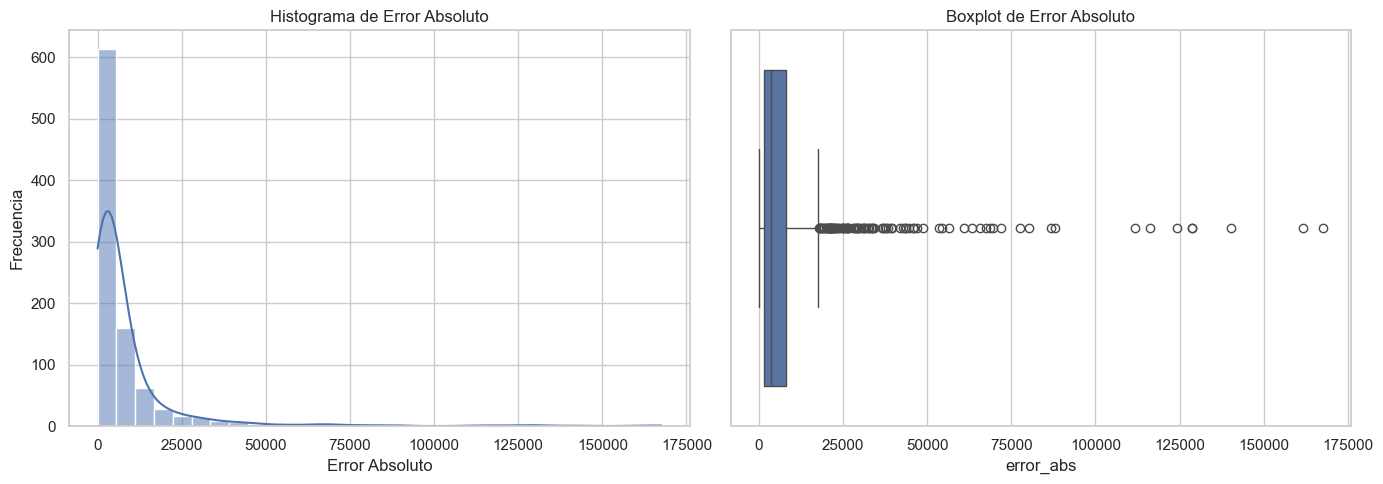

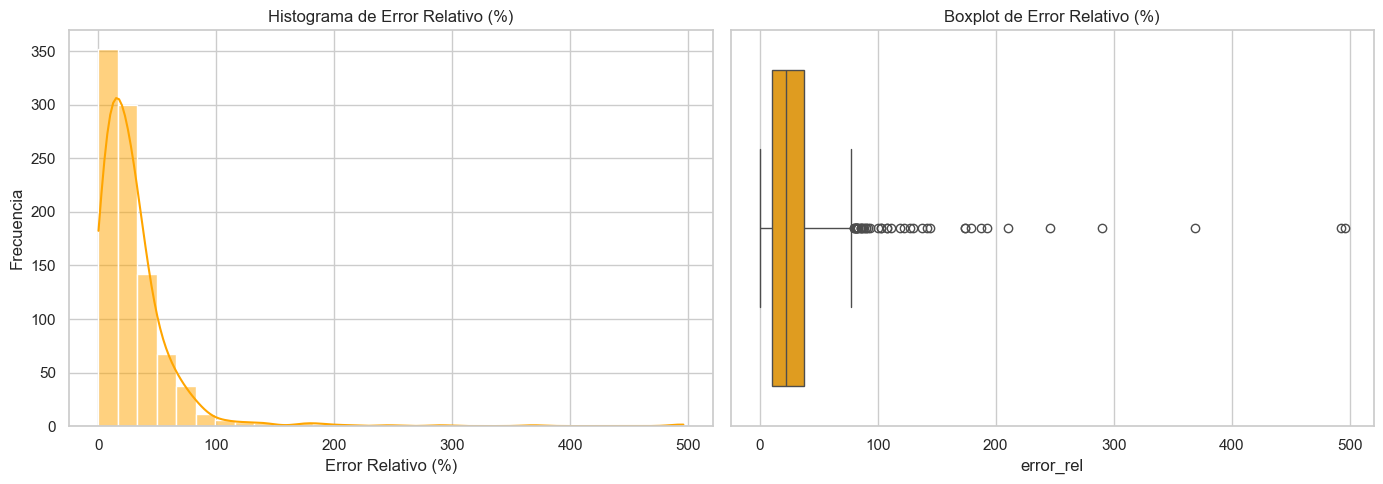

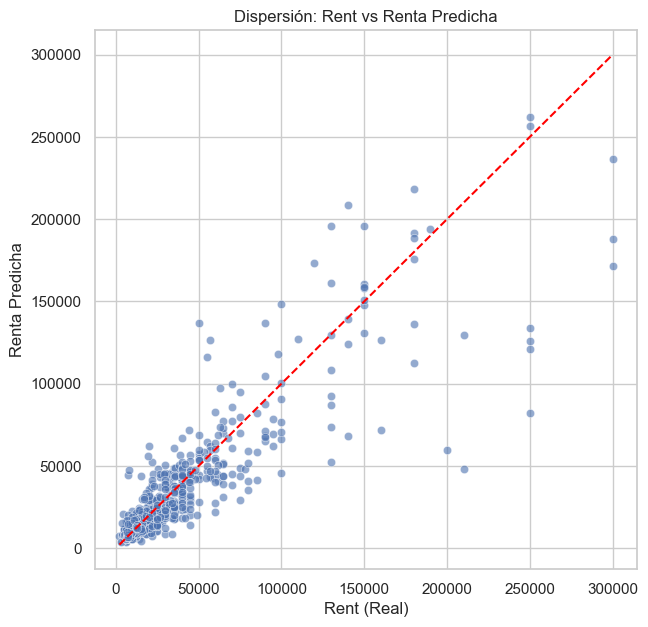

In [177]:
# Añadimos columnas de error absoluto y relativo
df_predicciones_completo['error_abs'] = abs(df_predicciones_completo['rent'] - df_predicciones_completo['Renta_Predicha'])
df_predicciones_completo['error_rel'] = df_predicciones_completo['error_abs'] / df_predicciones_completo['rent'] * 100

# Histograma y boxplot de errores absolutos
plt.figure(figsize=(14,5))

plt.subplot(1,2,1)
sns.histplot(df_predicciones_completo['error_abs'], bins=30, kde=True)
plt.title('Histograma de Error Absoluto')
plt.xlabel('Error Absoluto')
plt.ylabel('Frecuencia')

plt.subplot(1,2,2)
sns.boxplot(x=df_predicciones_completo['error_abs'])
plt.title('Boxplot de Error Absoluto')

plt.tight_layout()
plt.show()

# Histograma y boxplot de errores relativos (%)
plt.figure(figsize=(14,5))

plt.subplot(1,2,1)
sns.histplot(df_predicciones_completo['error_rel'], bins=30, kde=True, color='orange')
plt.title('Histograma de Error Relativo (%)')
plt.xlabel('Error Relativo (%)')
plt.ylabel('Frecuencia')

plt.subplot(1,2,2)
sns.boxplot(x=df_predicciones_completo['error_rel'], color='orange')
plt.title('Boxplot de Error Relativo (%)')

plt.tight_layout()
plt.show()

# Scatter plot rent vs Renta_Predicha con línea diagonal
plt.figure(figsize=(7,7))
sns.scatterplot(x='rent', y='Renta_Predicha', data=df_predicciones_completo, alpha=0.6)
plt.plot([df_predicciones_completo['rent'].min(), df_predicciones_completo['rent'].max()],
         [df_predicciones_completo['rent'].min(), df_predicciones_completo['rent'].max()],
         color='red', linestyle='--')
plt.title('Dispersión: Rent vs Renta Predicha')
plt.xlabel('Rent (Real)')
plt.ylabel('Renta Predicha')
plt.show()

In [178]:
df_predicciones_completo.groupby('city').agg({
    'rent': 'mean',
    'Renta_Predicha': 'mean',
    'bhk': 'count'  # cantidad de muestras
}).rename(columns={'bhk': 'count'}).sort_values(by='rent', ascending=False)

,rent,Renta_Predicha,count
city,,,
Mumbai,68097.363158,64880.502942,190
Delhi,27154.782609,22497.976736,115
Hyderabad,21191.573034,20425.521474,178
Chennai,20379.751445,17954.730803,173
Bangalore,17713.836478,16878.321797,159
Kolkata,10198.305085,11007.378976,118


In [180]:
df_predicciones_completo.groupby(['city', 'bhk']).agg({
    'rent': ['mean', 'median', 'count'],
    'Renta_Predicha': ['mean', 'median'],
}).reset_index()

city bhk           rent                 Renta_Predicha               
                            mean    median count           mean         median
0   Bangalore   1   10464.000000    9000.0    50    8807.003683    7973.989460
1   Bangalore   2   16672.289157   16000.0    83   15519.578984   13762.450166
2   Bangalore   3   33326.086957   30000.0    23   33086.321470   34190.613697
3   Bangalore   4   47666.666667   63000.0     3   64730.844022   77362.027871
4     Chennai   1    8727.272727    8250.0    22    7847.909981    7113.111136
5     Chennai   2   14069.201923   13000.0   104   13256.465461   12604.300149
6     Chennai   3   34897.727273   25500.0    44   30258.391782   24580.389407
7     Chennai   4  111666.666667   65000.0     3   74490.921008   70310.262183
8       Delhi   1   10756.756757   10000.0    37   10704.597914   10392.298927
9       Delhi   2   17500.000000   15000.0    47   16723.385692   13917.463967
10      Delhi   3   48934.615385   42150.0    26   43456.380533   39509.120898
11      Delhi   4  126000.000000  100000.0     5   55066.436090   45613.630697
12  Hyderabad   1    8100.000000    7500.0    23    8053.425527    7419.356865
13  Hyderabad   2   14182.105263   12500.0    95   14213.803502   13148.317193
14  Hyderabad   3   32179.245283   26000.0    53   31489.824575   24746.328298
15  Hyderabad   4   93600.000000   45000.0     5   72522.614779   56961.228514
16  Hyderabad   5   45000.000000   45000.0     1   32371.310397   32371.310397
17  Hyderabad   6   20000.000000   20000.0     1   36257.615780   36257.615780
18    Kolkata   1    7351.282051    6300.0    39    6458.475657    5637.915500
19    Kolkata   2    9685.454545    8500.0    55   10498.483931   10128.501232
20    Kolkata   3   15666.666667   14000.0    21   19301.468009   16773.692191
21    Kolkata   4   18333.333333   10000.0     3   21414.241366   19159.005216
22     Mumbai   1   28960.317460   27000.0    63   26776.212462   24217.304521
23     Mumbai   2   52573.333333   46000.0    75   50824.566369   47671.224465
24     Mumbai   3  122729.702703  100000.0    37  109319.798049  112568.039249
25     Mumbai   4  166428.571429  150000.0    14  181923.355962  190010.499789
26     Mumbai   5  300000.000000  300000.0     1  236792.185061  236792.185061

In [182]:
df_predicciones_completo.groupby(['city', 'furnish status']).agg({
    'rent': 'mean',
    'Renta_Predicha': 'mean'
}).reset_index()

,city,furnish status,rent,Renta_Predicha
0,Bangalore,Furnished,21833.333333,19495.046719
1,Bangalore,Semi-Furnished,17717.000000,17127.407234
2,Bangalore,Unfurnished,15428.947368,14776.748980
3,Chennai,Furnished,27188.722222,23238.046893
4,Chennai,Semi-Furnished,22659.090909,19036.283934
5,Chennai,Unfurnished,15556.716418,15114.785056
6,Delhi,Furnished,24857.142857,24340.703559
7,Delhi,Semi-Furnished,31677.272727,25019.652080
8,Delhi,Unfurnished,24140.000000,19504.957168
9,Hyderabad,Furnished,23045.454545,21614.395461


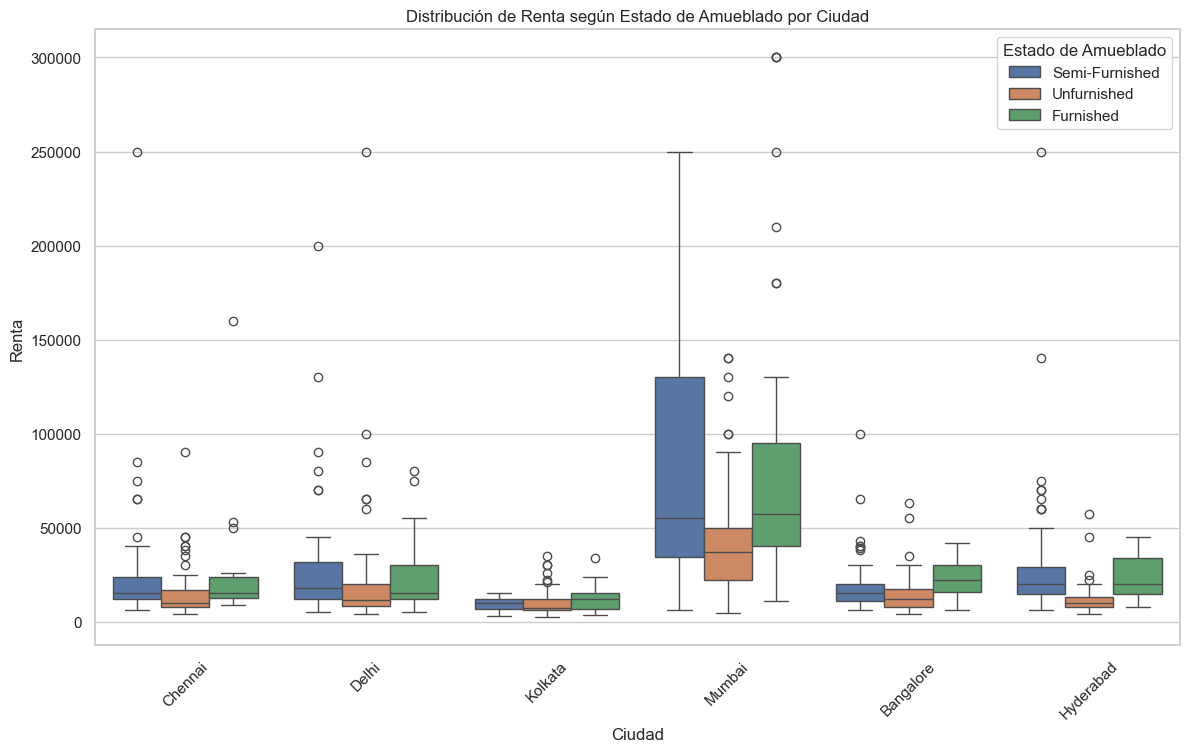

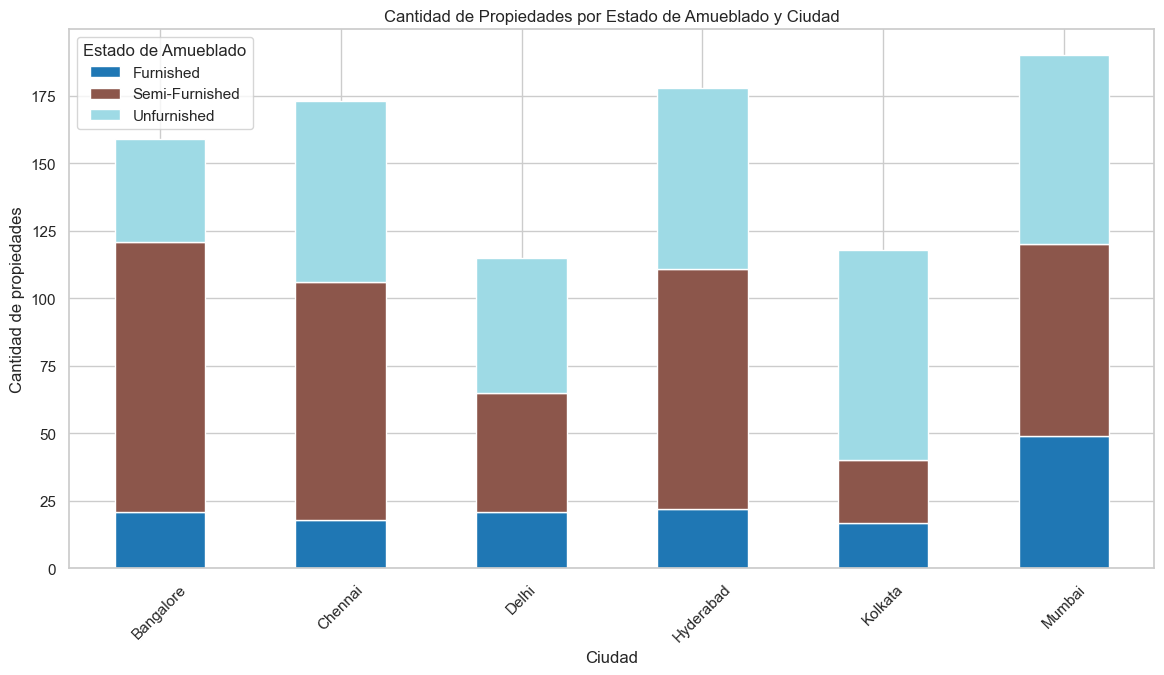

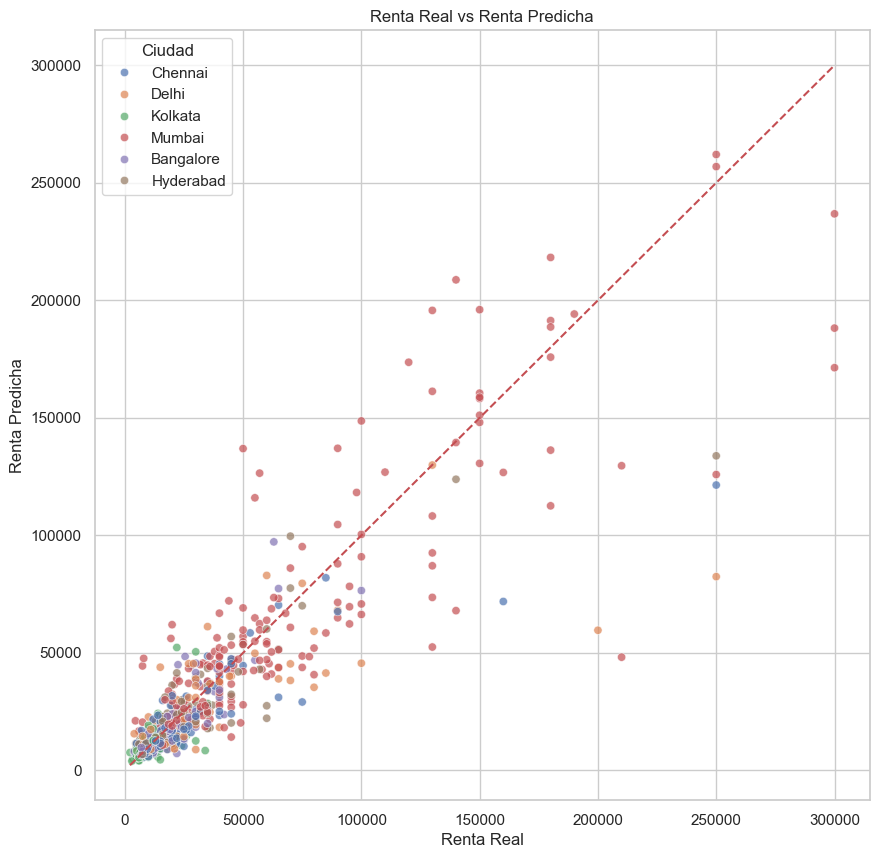

In [188]:
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 7)



# --- 2. Boxplot de renta según furnishing status por ciudad ---
plt.figure(figsize=(14,8))
sns.boxplot(data=df_predicciones_completo, x='city', y='rent', hue='furnish status')
plt.title("Distribución de Renta según Estado de Amueblado por Ciudad")
plt.xticks(rotation=45)
plt.ylabel("Renta")
plt.xlabel("Ciudad")
plt.legend(title="Estado de Amueblado")
plt.show()

# --- 3. Barras apiladas: cantidad de propiedades por furnishing y ciudad ---
# Primero tabla pivot con conteo
pivot_count = df_predicciones_completo.groupby(['city', 'furnish status']).size().unstack(fill_value=0)
pivot_count.plot(kind='bar', stacked=True, figsize=(14,7), colormap='tab20')
plt.title("Cantidad de Propiedades por Estado de Amueblado y Ciudad")
plt.ylabel("Cantidad de propiedades")
plt.xlabel("Ciudad")
plt.xticks(rotation=45)
plt.legend(title="Estado de Amueblado")
plt.show()

# --- 4. Scatter plot: Renta real vs Renta predicha ---
plt.figure(figsize=(10,10))
sns.scatterplot(data=df_predicciones_completo, x='rent', y='Renta_Predicha', hue='city', alpha=0.7)
plt.plot([df_predicciones_completo['rent'].min(), df_predicciones_completo['rent'].max()], [df_predicciones_completo['rent'].min(), df_predicciones_completo['rent'].max()], 'r--')  # línea 45°
plt.title("Renta Real vs Renta Predicha")
plt.xlabel("Renta Real")
plt.ylabel("Renta Predicha")
plt.legend(title='Ciudad')
plt.show()

## 5. Conclusiones


### ANALISIS DE LA RENTABILIDAD DE LAS CIUDADES  y TIPO DE PISO 

- Calcular:
    - rentabilidad por city
    - rentabilidad por bhk
    - rentabilidad por tennant prefered. 
)

In [189]:
# Filtramos para excluir Mumbai
df_sin_mumbai = df_predicciones_completo[df_predicciones_completo['city'] != 'Mumbai']

# Calculamos renta media predicha por ciudad
renta_media_ciudad = df_sin_mumbai.groupby('city')['Renta_Predicha'].mean().sort_values(ascending=False)

print(renta_media_ciudad)


city
Delhi        22497.976736
Hyderabad    20425.521474
Chennai      17954.730803
Bangalore    16878.321797
Kolkata      11007.378976
Name: Renta_Predicha, dtype: float64


In [190]:
renta_media_bhk_ciudad = df_sin_mumbai.groupby(['city', 'bhk'])['Renta_Predicha'].mean().unstack()

print(renta_media_bhk_ciudad)


bhk                   1             2             3             4  \
city                                                                
Bangalore   8807.003683  15519.578984  33086.321470  64730.844022   
Chennai     7847.909981  13256.465461  30258.391782  74490.921008   
Delhi      10704.597914  16723.385692  43456.380533  55066.436090   
Hyderabad   8053.425527  14213.803502  31489.824575  72522.614779   
Kolkata     6458.475657  10498.483931  19301.468009  21414.241366   

bhk                   5            6  
city                                  
Bangalore           NaN          NaN  
Chennai             NaN          NaN  
Delhi               NaN          NaN  
Hyderabad  32371.310397  36257.61578  
Kolkata             NaN          NaN  


In [191]:
cantidad_viviendas_ciudad = df_sin_mumbai['city'].value_counts()

print(cantidad_viviendas_ciudad)


city
Hyderabad    178
Chennai      173
Bangalore    159
Kolkata      118
Delhi        115
Name: count, dtype: int64


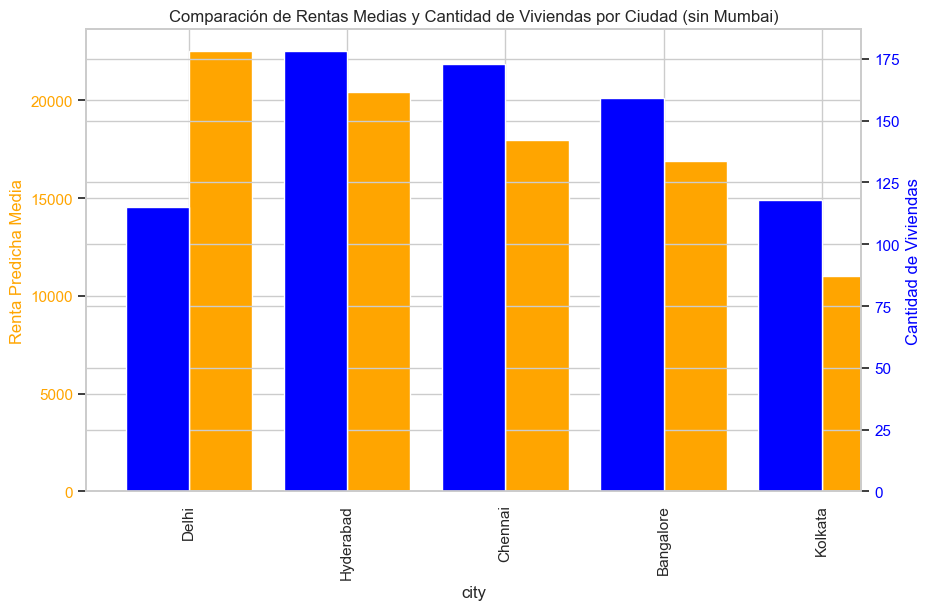

In [192]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(figsize=(10,6))

renta_media_ciudad.plot(kind='bar', color='orange', ax=ax1, position=0, width=0.4)
ax1.set_ylabel('Renta Predicha Media', color='orange')
ax1.tick_params(axis='y', labelcolor='orange')

ax2 = ax1.twinx()
cantidad_viviendas_ciudad.loc[renta_media_ciudad.index].plot(kind='bar', color='blue', ax=ax2, position=1, width=0.4)
ax2.set_ylabel('Cantidad de Viviendas', color='blue')
ax2.tick_params(axis='y', labelcolor='blue')

plt.title('Comparación de Rentas Medias y Cantidad de Viviendas por Ciudad (sin Mumbai)')
plt.show()


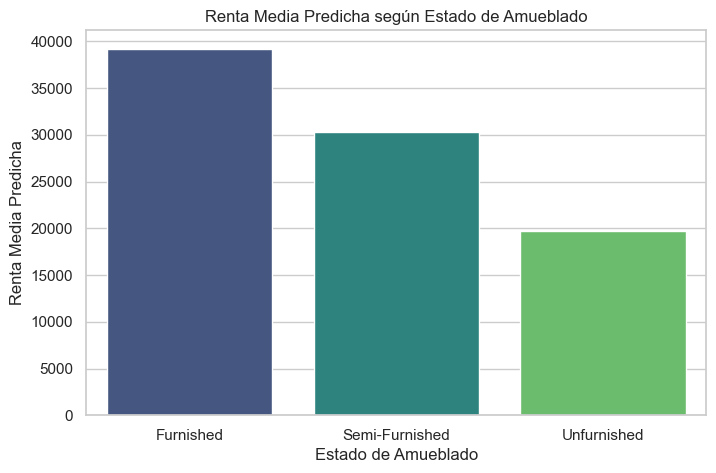

In [194]:
# Renta media predicha por estado de amueblado
renta_media_furnish = df_predicciones_completo.groupby('furnish status')['Renta_Predicha'].mean().sort_values(ascending=False)



plt.figure(figsize=(8,5))
sns.barplot(x=renta_media_furnish.index, y=renta_media_furnish.values, palette="viridis")
plt.title('Renta Media Predicha según Estado de Amueblado')
plt.xlabel('Estado de Amueblado')
plt.ylabel('Renta Media Predicha')
plt.show()

#### 3.3 Resumen y comparativas de modelos 
- Creamos un cuadro de comparacion para ver el rendimiento de cada uno 
- Comparamos metricas MAE, RMSE y R2